In [15]:
import pickle
import datetime
import time
import ConfigParser
import string

import scipy
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

import tweepy

from collections import Counter

from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
#global constants
FIG_SIZE = (15, 6)
NEG_TWEET = -1
POS_TWEET = 1
NEUT_TWEET = 0

TOP_WORDS = 10
TOPICS_COUNT = 20

#почему-то нет некоторых знаков пунктуации и части стоп-слов
russian_stops = [ u'без', u'более', u'бы', u'был', u'была', u'были', u'было', u'быть', u'вам', u'вас', u'ведь', u'весь', u'вдоль', u'вместо', u'вне', u'вниз', u'внизу', u'внутри', u'во', u'вокруг', u'вот', u'все', u'всегда', u'всего', u'всех', u'вы', u'где', u'да', u'давай', u'давать', u'даже', u'для', u'до', u'достаточно', u'его', u'ее', u'её', u'если', u'есть', u'ещё', u'же', u'за', u'заисключением', u'здесь', u'из', u'из-за', u'или', u'им', u'иметь', u'их', u'как', u'как-то', u'кто', u'когда', u'кроме', u'кто', u'ли', u'либо', u'мне', u'может', u'мои', u'мой', u'мы', u'на', u'навсегда', u'над', u'надо', u'наш', u'не', u'него', u'неё', u'нет', u'ни', u'них', u'но', u'ну', u'об', u'однако', u'он', u'она', u'они', u'оно', u'от', u'отчего', u'очень', u'по', u'под', u'после', u'потому', u'потомучто', u'почти', u'при', u'про', u'снова', u'со', u'так', u'также', u'такие', u'такой', u'там', u'те', u'тем', u'то', u'того', u'тоже', u'той', u'только', u'том', u'тут', u'ты', u'уже', u'хотя', u'чего', u'чего-то', u'чей', u'чем', u'что', u'чтобы', u'чьё', u'чья', u'эта', u'эти', u'это']
custom_stops = [u'...', u'ещё', u'это', u'весь', u'..', u'—', u'я', u'и', u'a', u'\u2026', u'rt', 'rt', u'всё']
university_names = [u'МФТИ', u'СПбГУ', u'МГУ', u'ИТМО']
custom_stops += russian_stops
stops = set(stopwords.words('russian') + list(string.punctuation) + custom_stops + list(string.digits) + university_names)

In [3]:
tknzr = TweetTokenizer()
def tweet_tokenize(msg):
    return tknzr.tokenize(msg)

def remove_retweet(msg):
    return ' '.join(filter(lambda x:x[0]!='@' and not x.startswith('http'), msg.split()))

def remove_stop_words(words):
    return [w for w in words if w not in stops]
    
def rename_sentiment(s):
    if s == -1:
        return 'neg'
    elif s == 0:
        return 'neut'
    else:
        return 'pos'

In [4]:
def color_types(ttype):
    color = 'red' if ttype == 'neg' else 'green'
    return 'color: %s' % color

In [5]:
with open('webapp/models/model_sgd.pkl', 'rb') as f:
    model = pickle.load(f)

with open('webapp/models/vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [6]:
SENTIMENT_THRESHOLD = 0.6
def convert_proba(p):
    if p[0] >= SENTIMENT_THRESHOLD:
        return NEG_TWEET
    elif p[1] >= SENTIMENT_THRESHOLD:
        return POS_TWEET
    else:
        return NEUT_TWEET

In [7]:
def plot_count(X):
    X['ttype'] = X['ttype'].apply(rename_sentiment)
    for p in np.arange(0.5, 0.7, 0.05):
        SENTIMENT_THRESHOLD = p
        universities = list(X['tuniversity'].unique())
        for u in universities:        
            plt.figure()

            ax = sns.countplot(x='ttype', data=X[X['tuniversity'] == u])
            plt.title(u + ' '+ str(p))

In [8]:
def plot_weights(X):
    for u in X['tuniversity'].unique():
        X_univ = X[X['tuniversity'] == u]
        X_pos = list(X_univ[X_univ['ttype'] == POS_TWEET]['ttext'])

        words = list()

        for s in X_pos:
            words += remove_stop_words(tweet_tokenize(s))

        words_counts = Counter(words)
        words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

        pos_words = words_counts[-15:]

        X_neg = list(X_univ[X_univ['ttype'] == NEG_TWEET]['ttext'])

        words = list()

        for s in X_neg:
            words += remove_stop_words(tweet_tokenize(s))

        words_counts = Counter(words)
        words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

        neg_words = words_counts[-15:]

        plt.figure(figsize=FIG_SIZE)
        sns.barplot(x=[w[0] for w in pos_words], y=[w[1] for w in pos_words])
        sns.plt.title(u + ' Positive')

        plt.figure(figsize=FIG_SIZE)
        sns.barplot(x=[w[0] for w in neg_words], y=[w[1] for w in neg_words])
        sns.plt.title(u + ' Negative')

In [66]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #%d:' % topic_idx)
        print(' '.join([str((feature_names[i], topic[i]))
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def plot_top_words(model, feature_names, n_top_words, u):
    for topic_idx, topic in enumerate(model.components_):
        data_sorted = [(feature_names[i], topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
        
        fig = plt.figure(figsize=FIG_SIZE)
        sns.barplot(x=[w[0] for w in data_sorted], y=[w[1] for w in data_sorted])
        sns.plt.title("%s Topic #%d:" % (u, topic_idx))
        fig.show()

In [215]:
def topics_by_university(X):
    for u in X['tuniversity'].unique():
        X_univ = X[X['tuniversity'] == u]
        
        tf_vectorizer = CountVectorizer(min_df = 3, max_df = 0.95, stop_words = stops.add(u.lower()), tokenizer = tweet_tokenize)
        tf = tf_vectorizer.fit_transform(X_univ['ttext'].apply(remove_retweet))

        lda = LatentDirichletAllocation(n_topics=TOPICS_COUNT, max_iter=100,
                                        learning_method='online', learning_offset=50.,
                                        random_state=0).fit(tf)
        
        tf_feature_names = tf_vectorizer.get_feature_names()
        plot_top_words(lda, tf_feature_names, TOP_WORDS, u)
     
    
def determine_topics(probs):
    return np.where(probs == probs.max())[0]
   
def topics_distribution(X):
    for u in X['tuniversity'].unique():
        X_univ = X[X['tuniversity'] == u]
        
        tf_vectorizer = CountVectorizer(min_df = 3, max_df = 0.95, stop_words = stops.add(u.lower()), tokenizer = tweet_tokenize)
        tf = tf_vectorizer.fit_transform(X_univ['ttext'].apply(remove_retweet))

        probs = LatentDirichletAllocation(n_topics=TOPICS_COUNT, max_iter=100,
                                        learning_method='online', learning_offset=50.,
                                        random_state=0).fit_transform(tf)
        
        topics = list()
        for p in probs:
            topics.append(determine_topics(p))

        topics_stats = np.array([0.]*TOPICS_COUNT)
        
        for t in topics:
            for t_num in t:
                topics_stats[t_num] += 1
                
        topics_stats /= X_univ.shape[0]
                
        plt.figure(figsize=FIG_SIZE)
        sns.barplot(x=['#%d' % i for i in range(TOPICS_COUNT)], y=topics_stats)
        sns.plt.title(u)

In [42]:
config = ConfigParser.ConfigParser()
config.read('webapp/config.ini')

['webapp/config.ini']

In [10]:
engine = create_engine('postgresql://%s:%s@localhost/tweets_db' %
                        (config.get('DatabaseLogin', 'login'), config.get('DatabaseLogin', 'password')))
X = pd.read_sql_table('tweets', engine)

In [11]:
X['ttype'] = np.apply_along_axis(convert_proba, 1, model.predict_proba(vectorizer.transform(X['ttext'].apply(remove_retweet))))

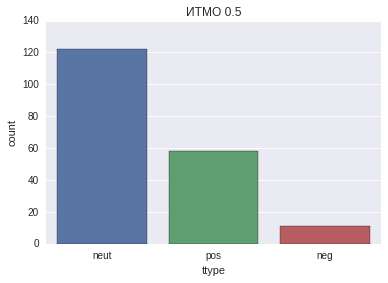

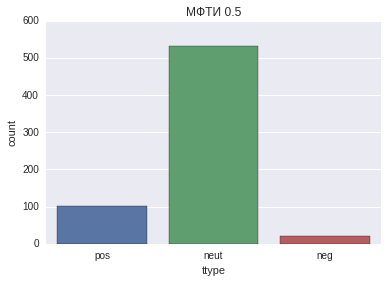

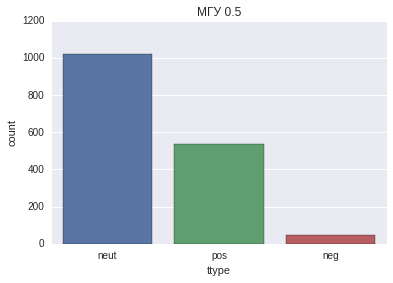

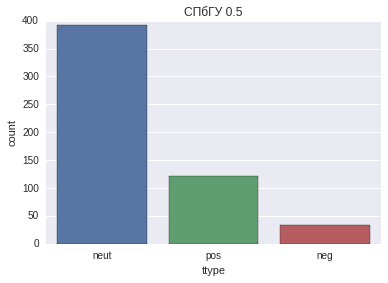

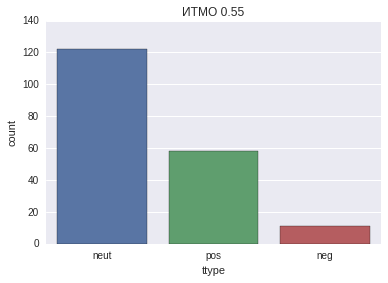

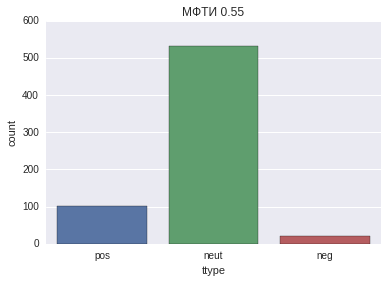

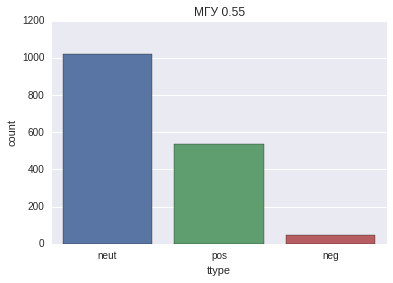

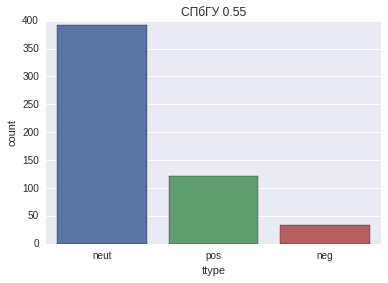

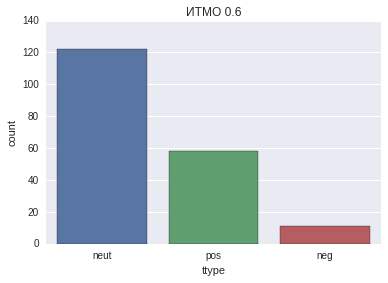

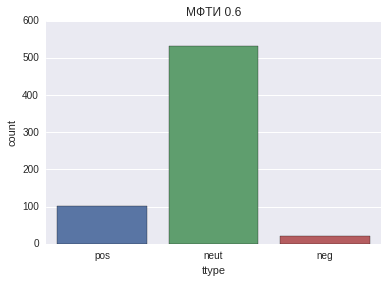

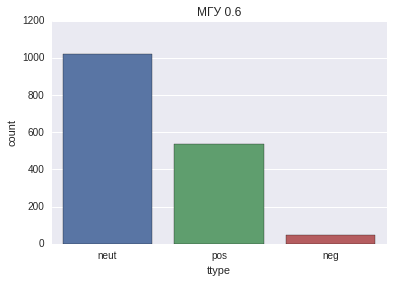

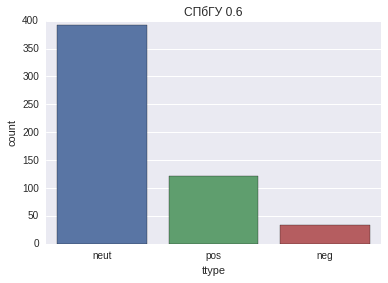

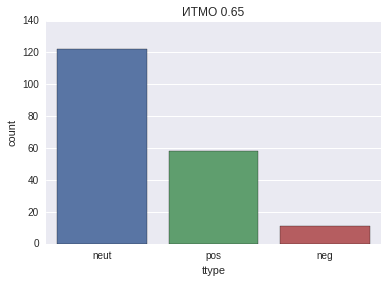

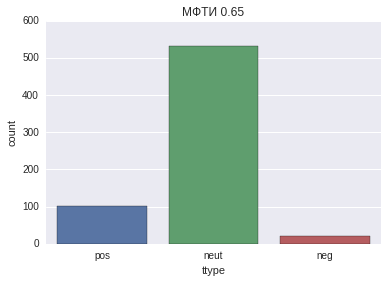

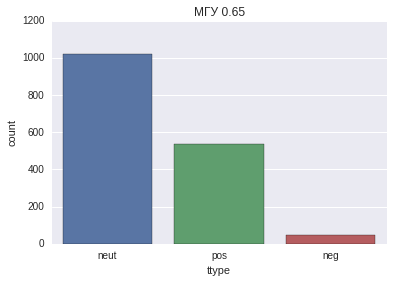

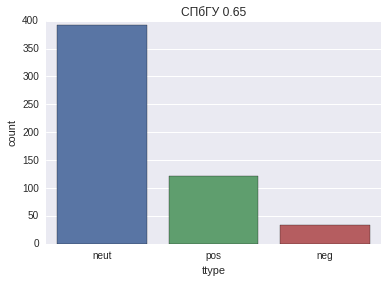

In [12]:
plot_count(X)

In [13]:
X['ttype'] = model.predict(vectorizer.transform(X['ttext'].apply(remove_retweet)))

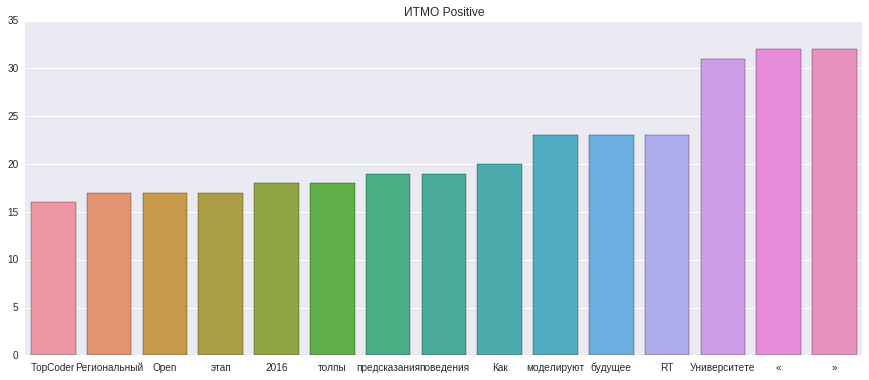

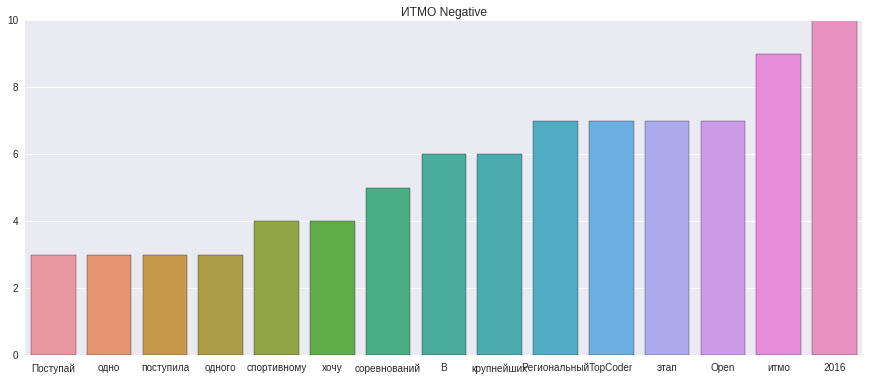

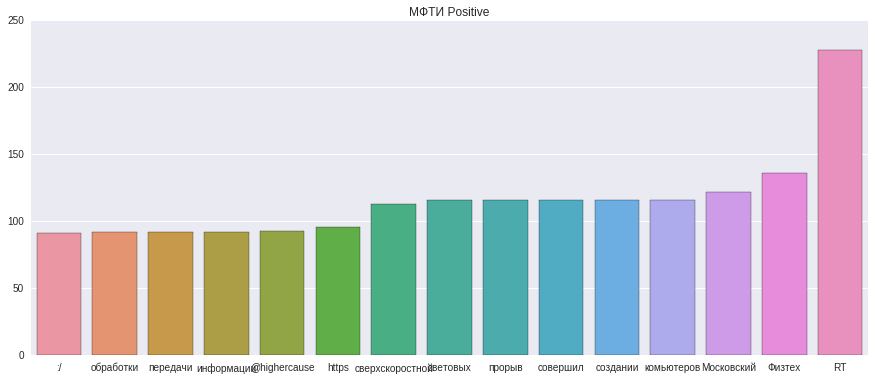

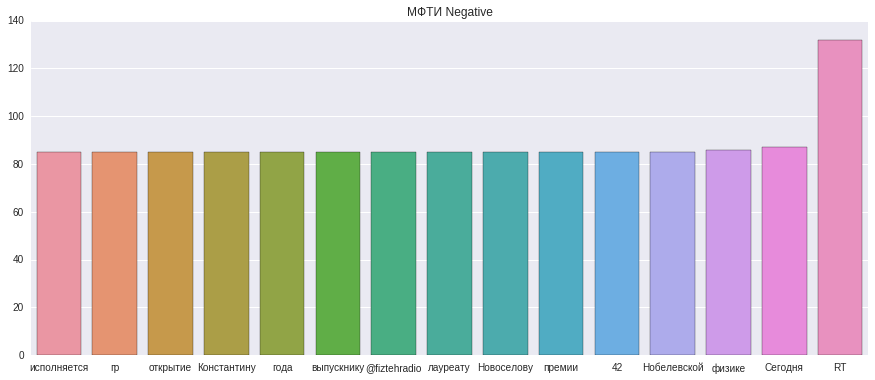

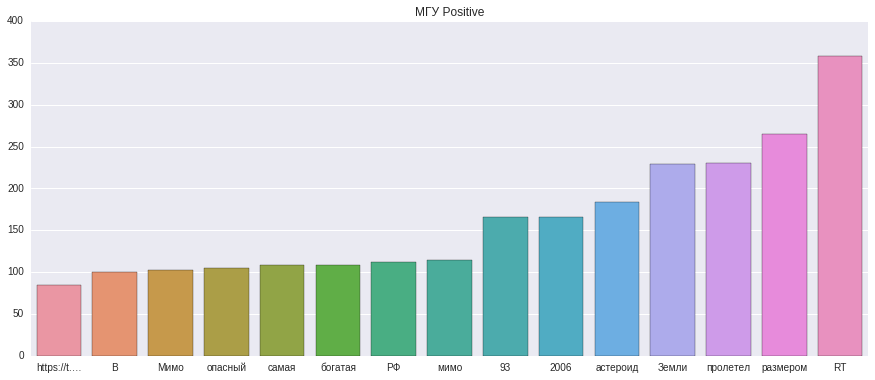

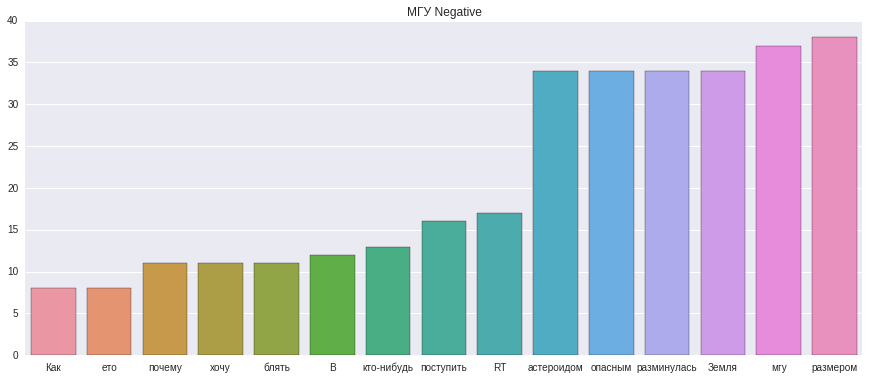

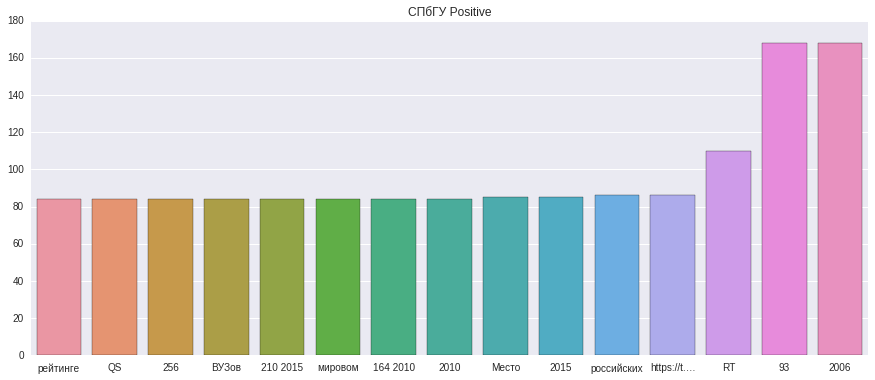

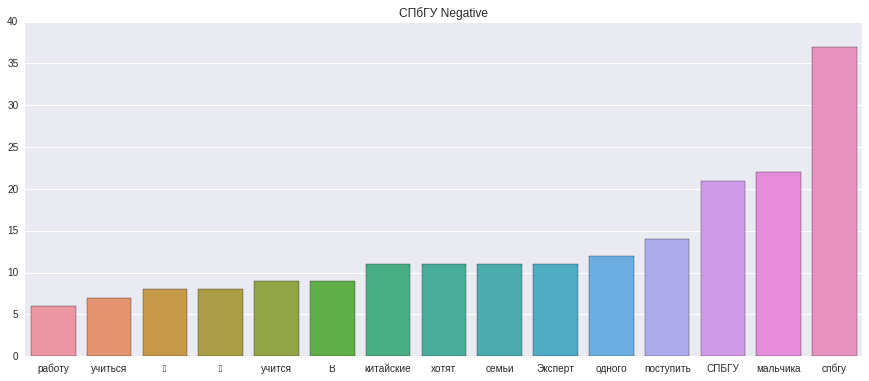

In [14]:
plot_weights(X)

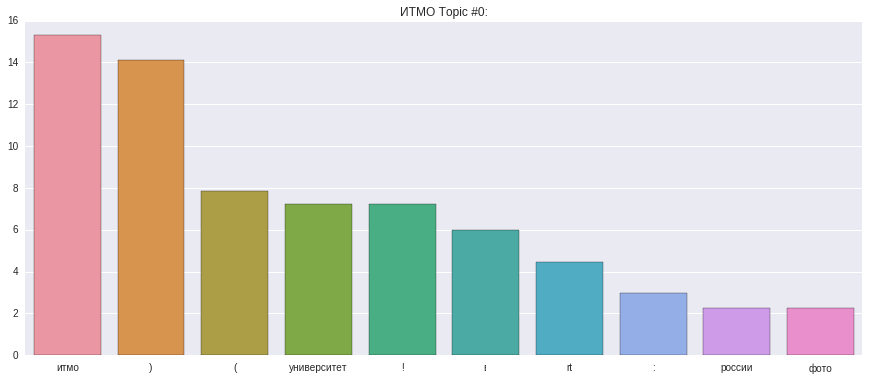

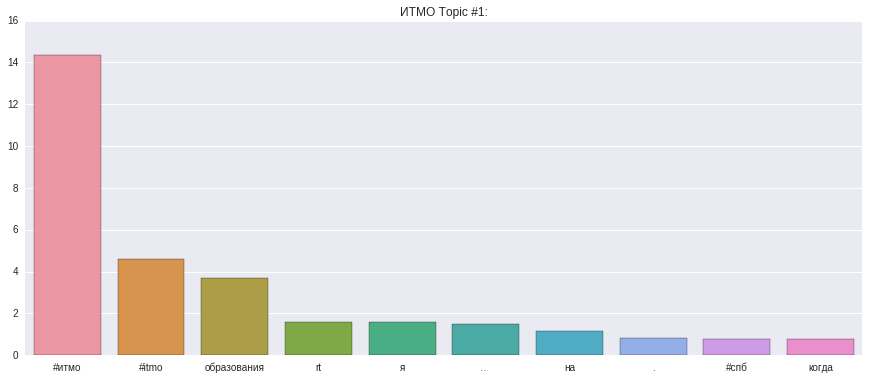

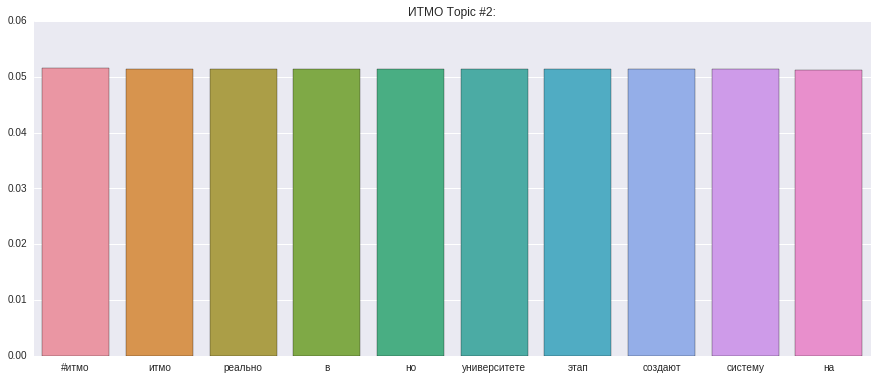

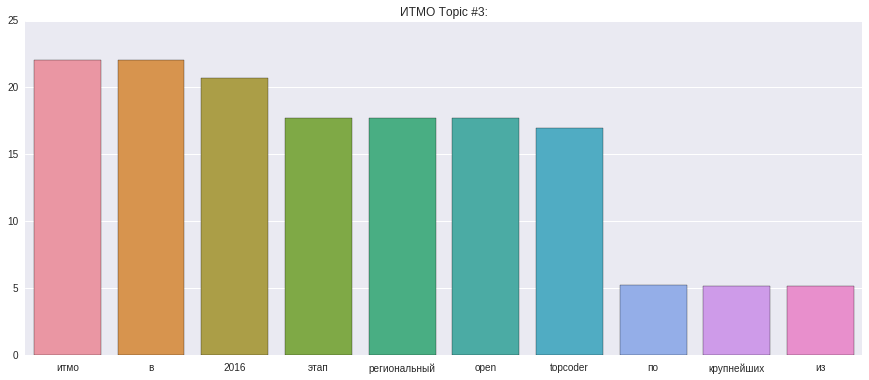

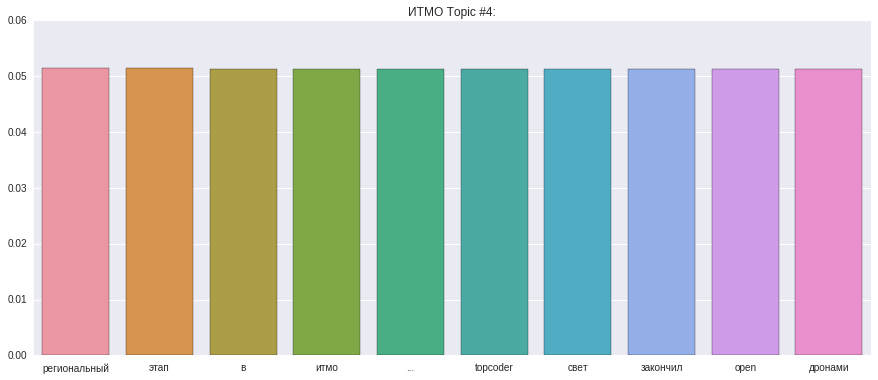

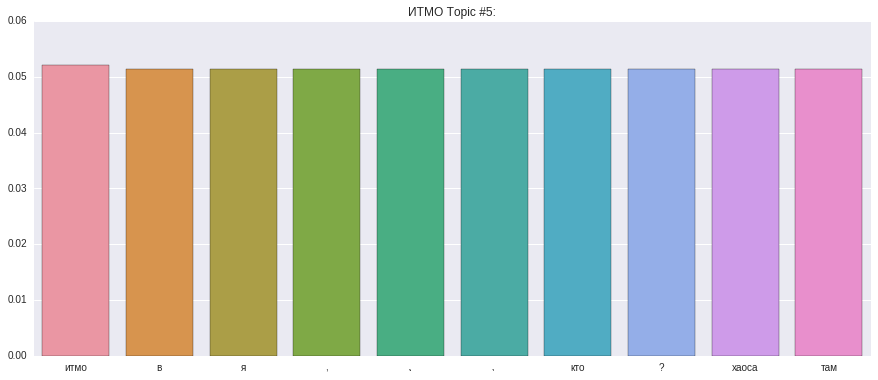

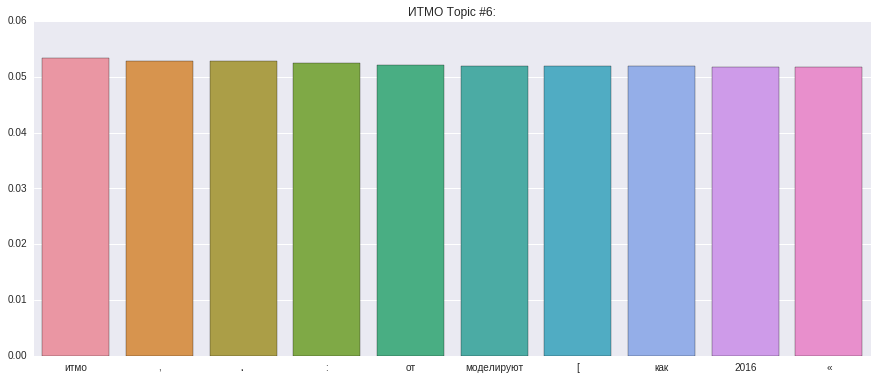

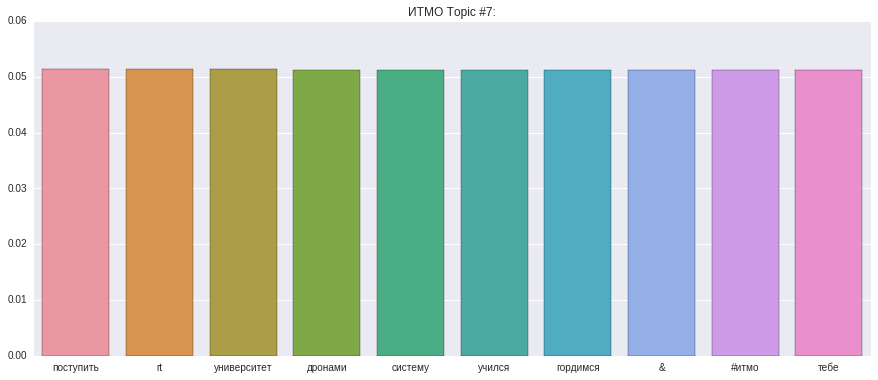

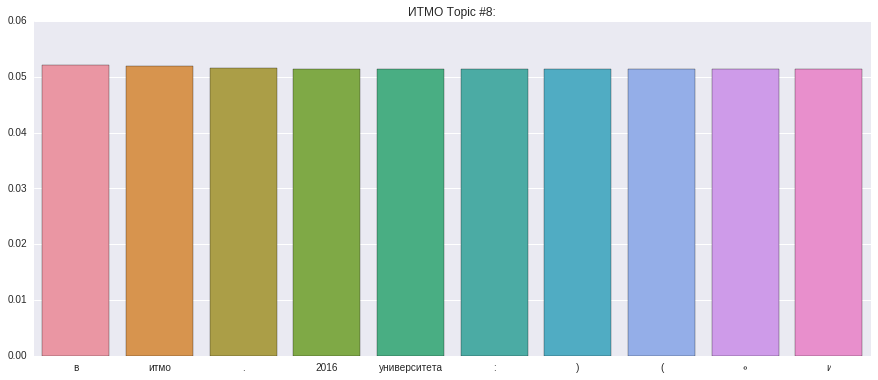

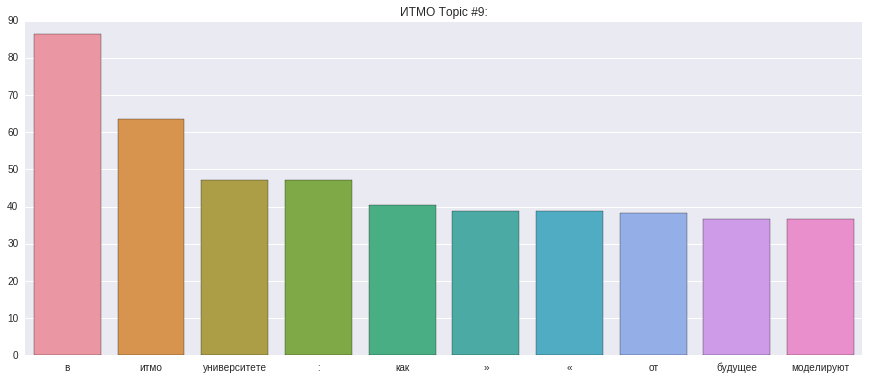

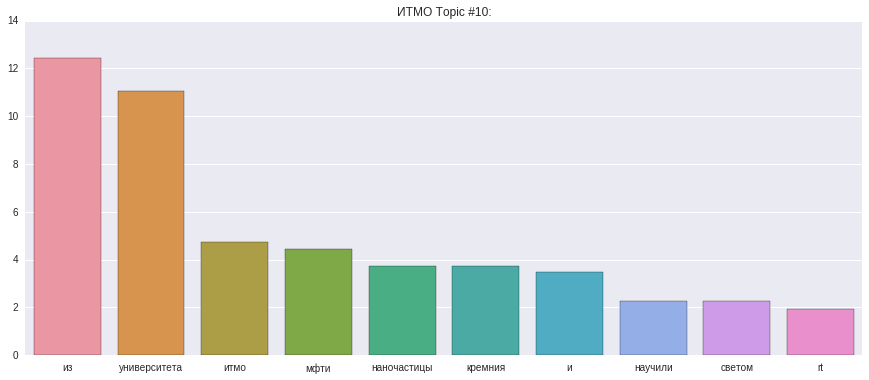

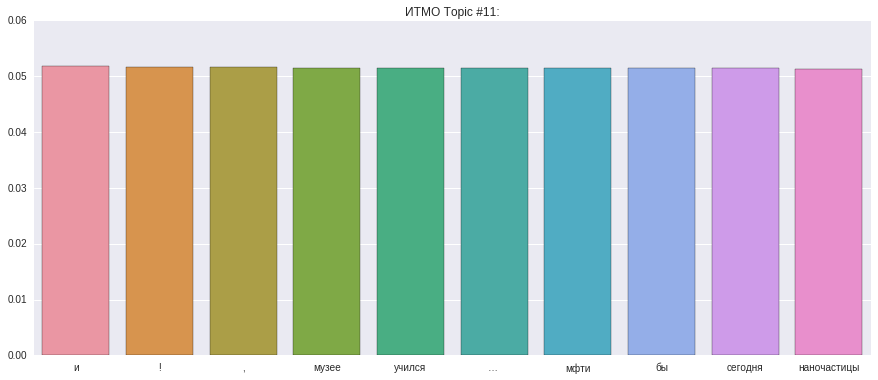

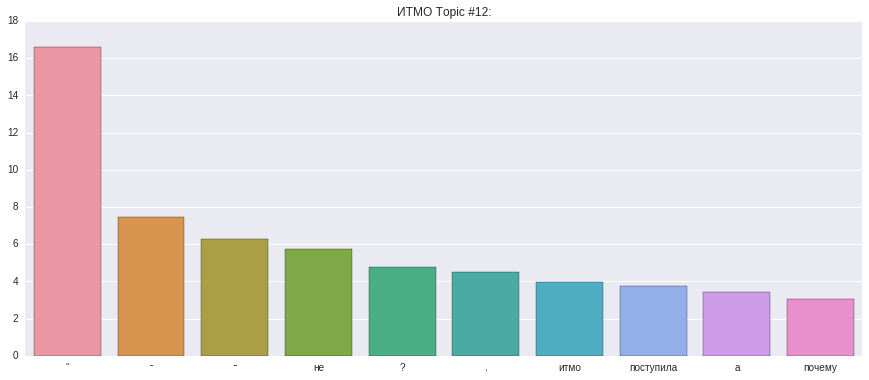

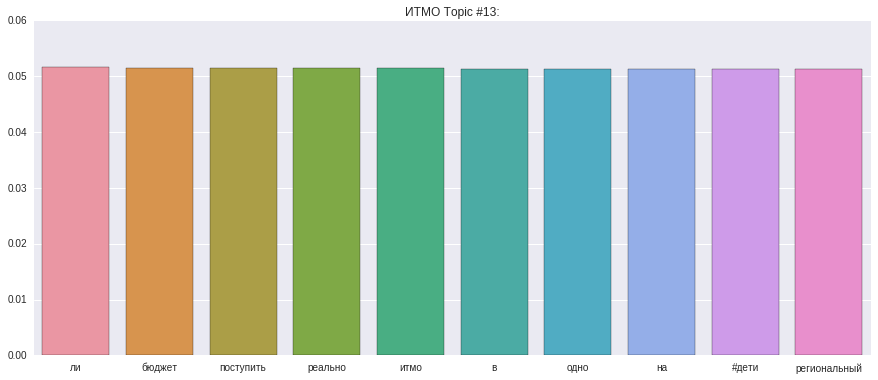

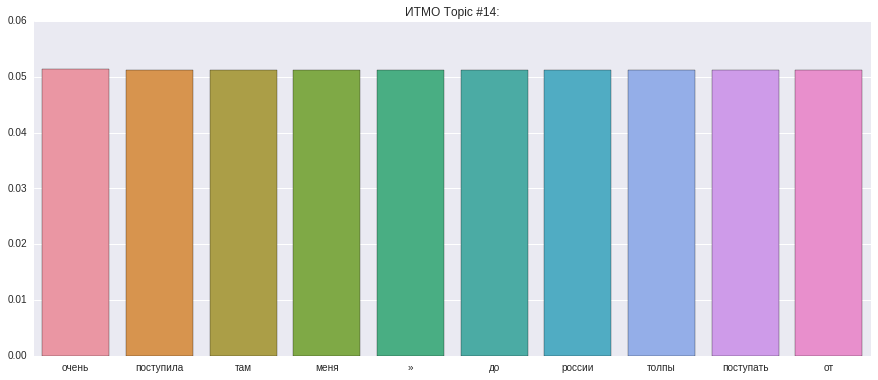

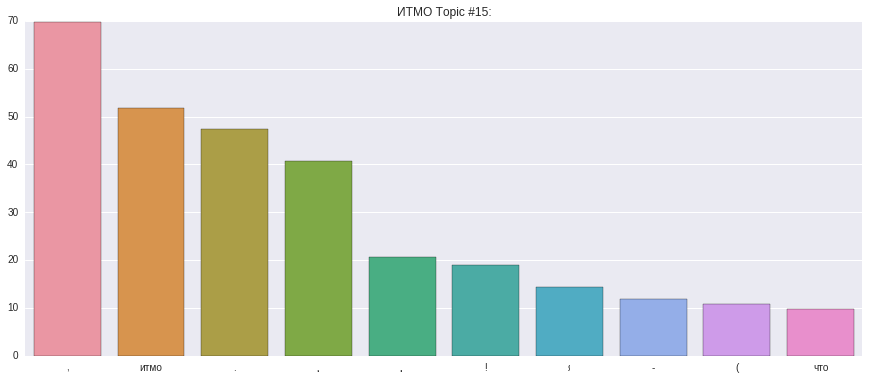

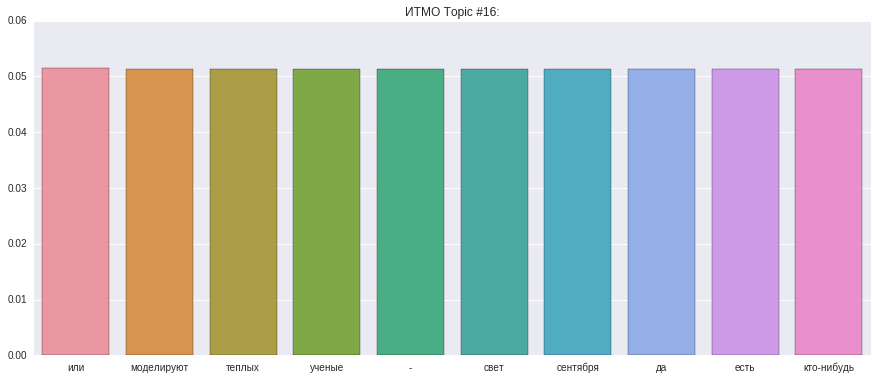

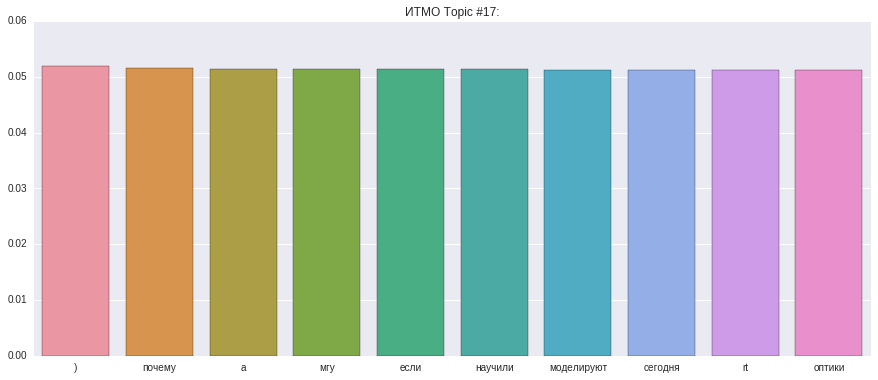

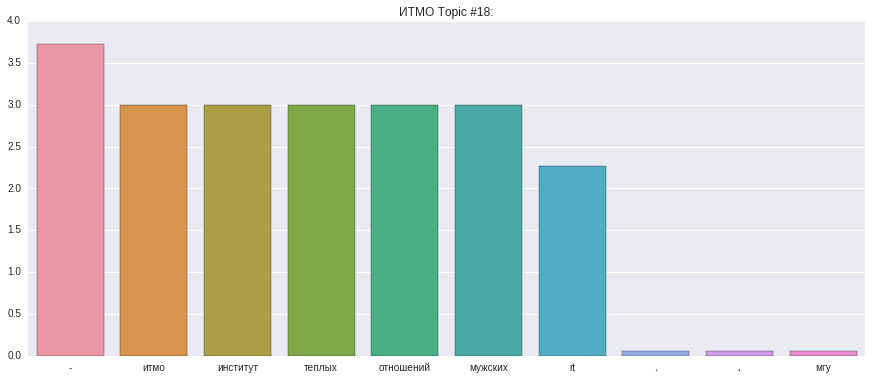

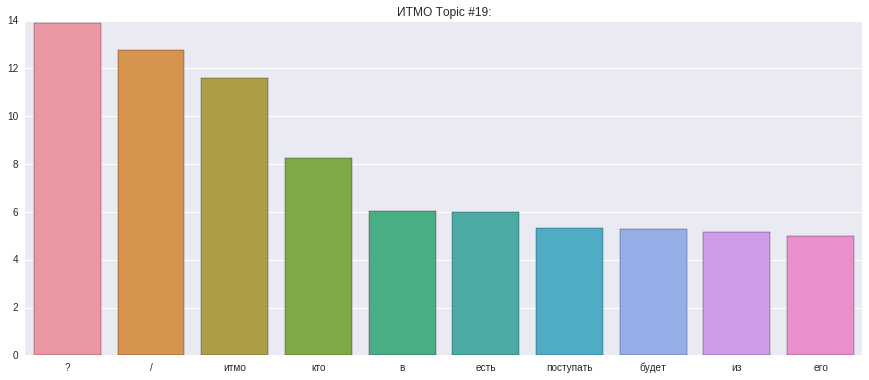

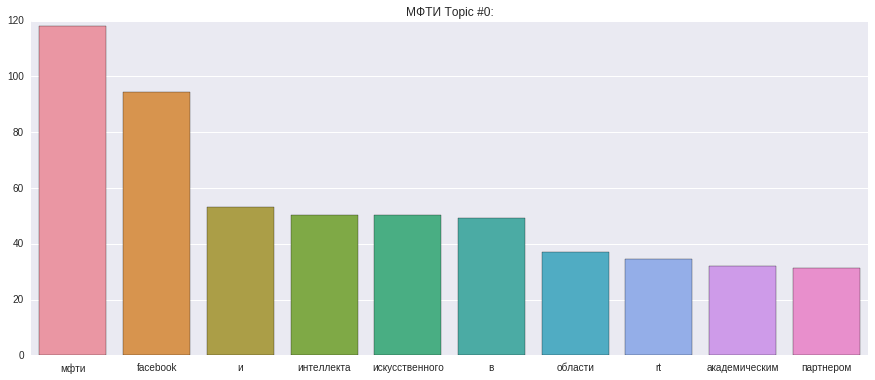

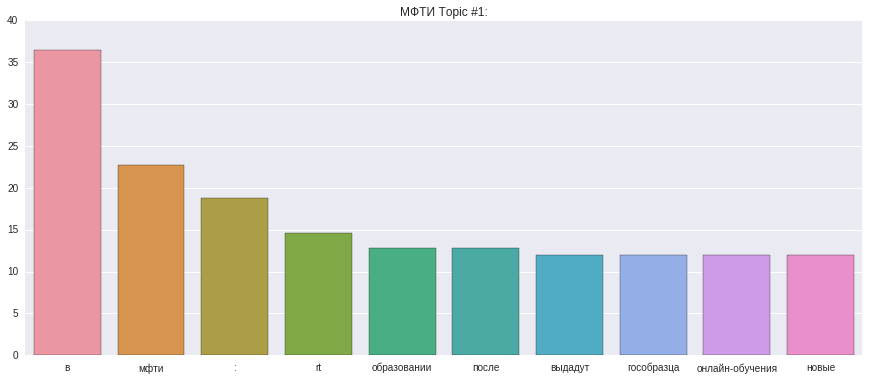

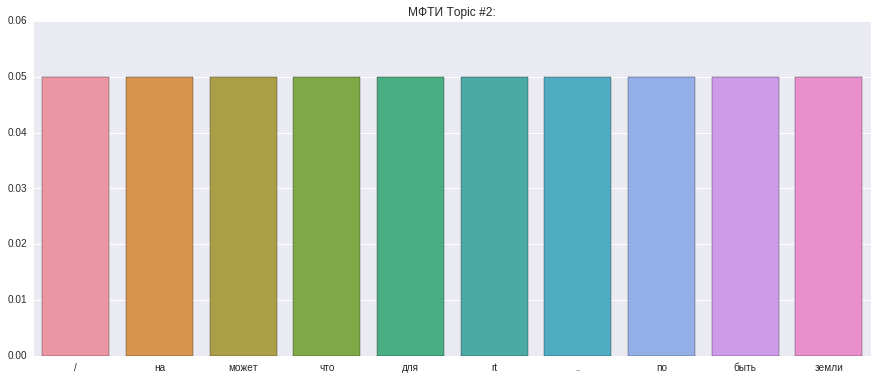

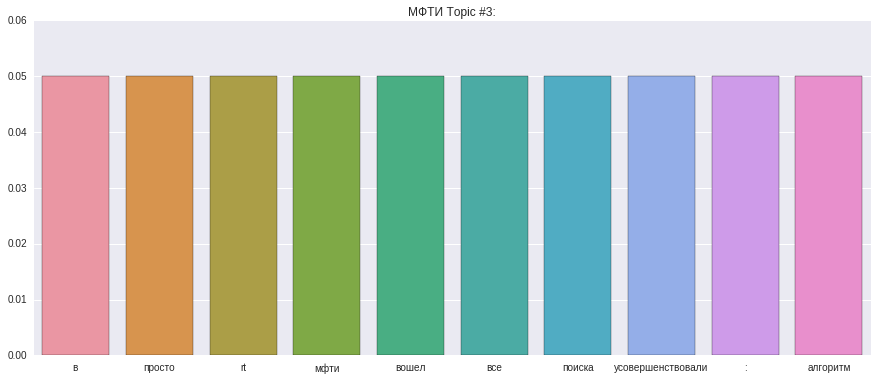

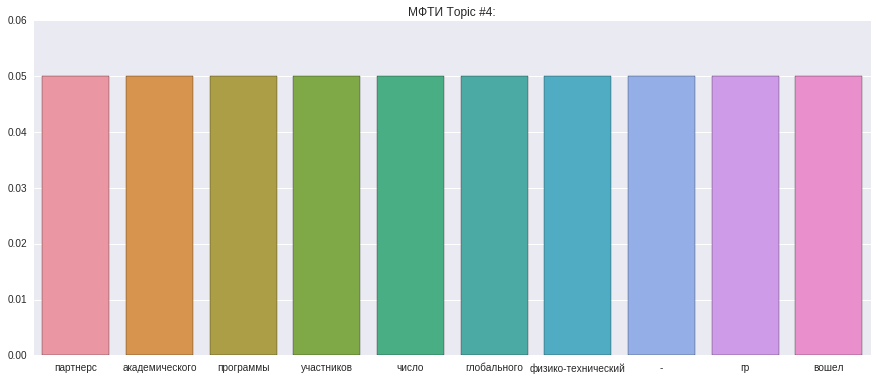

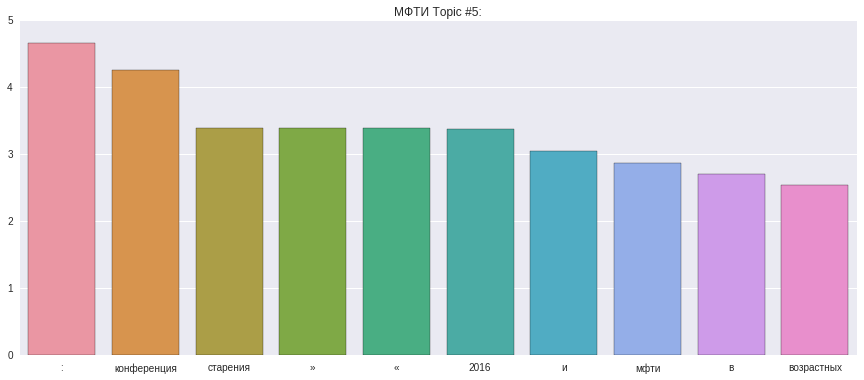

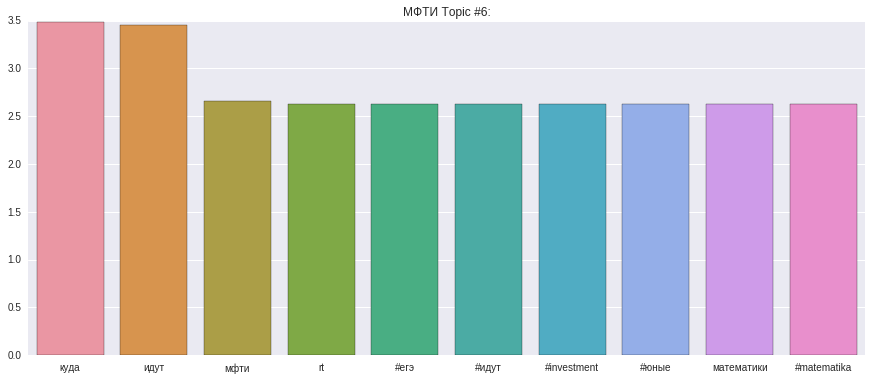

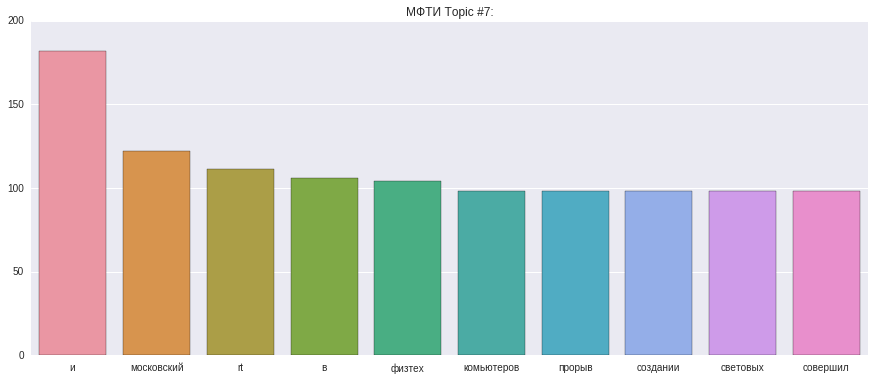

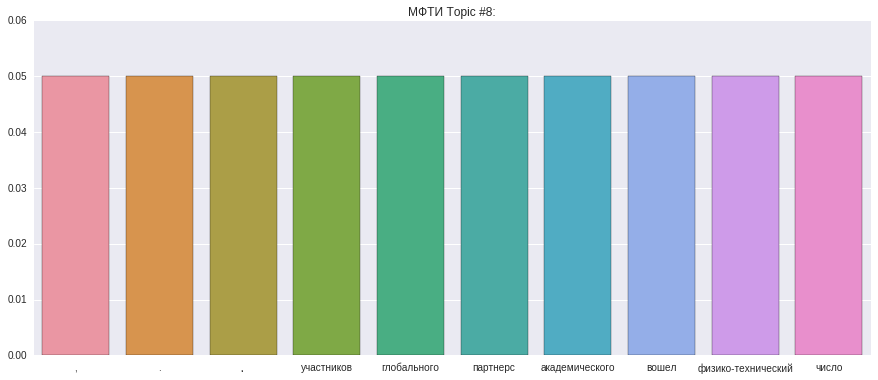

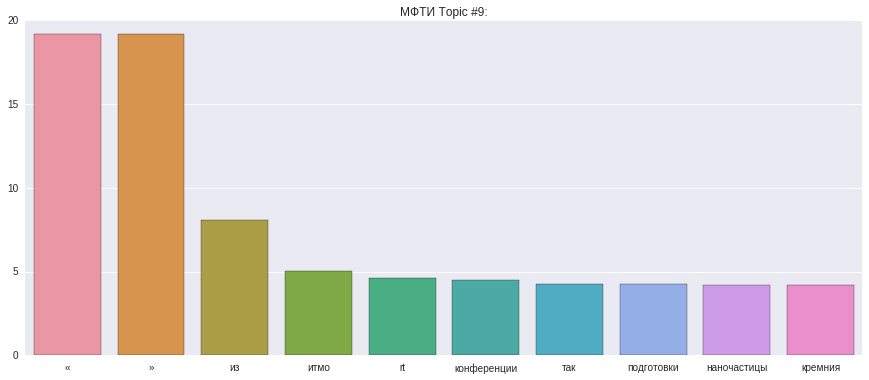

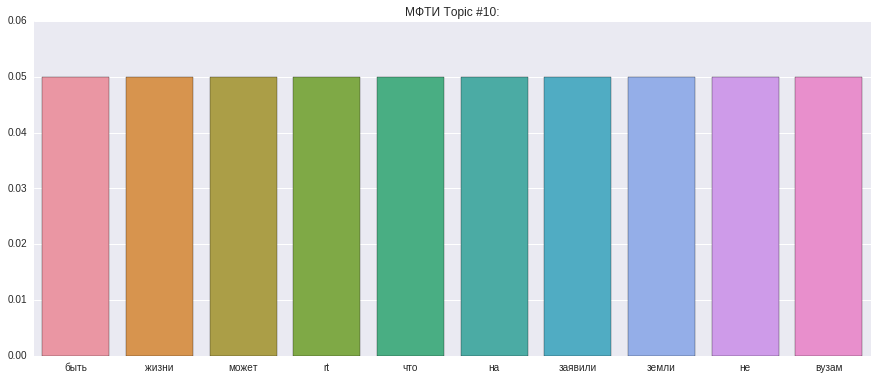

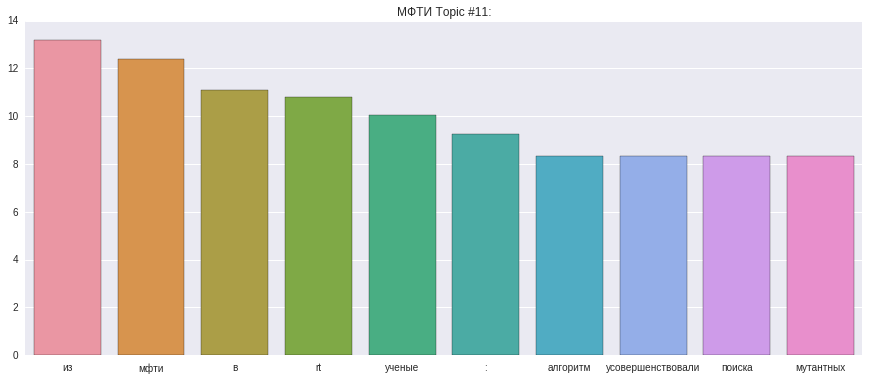

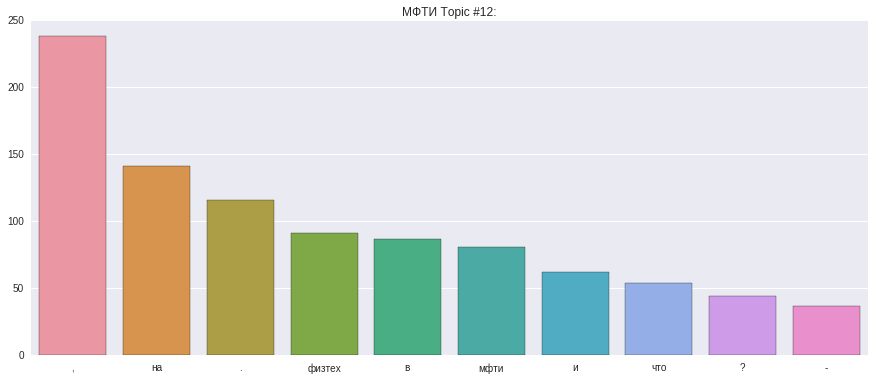

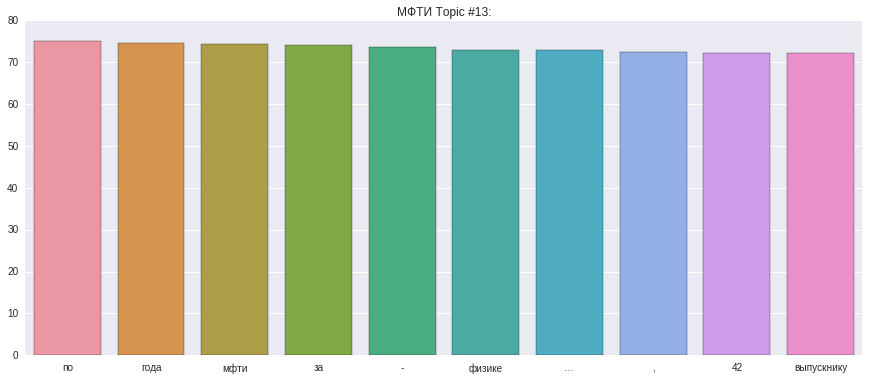

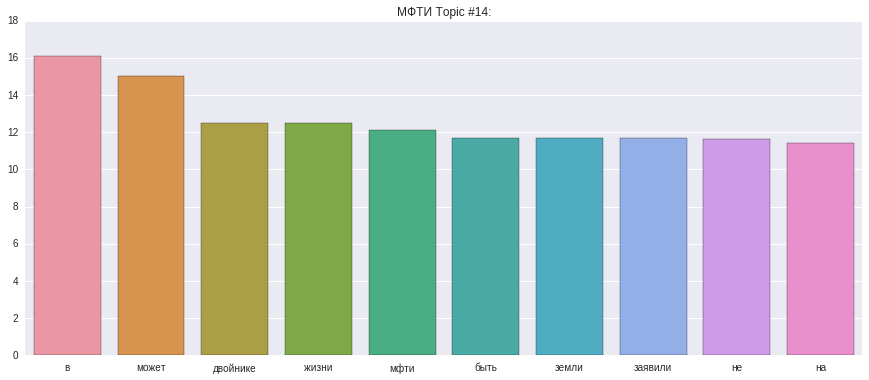

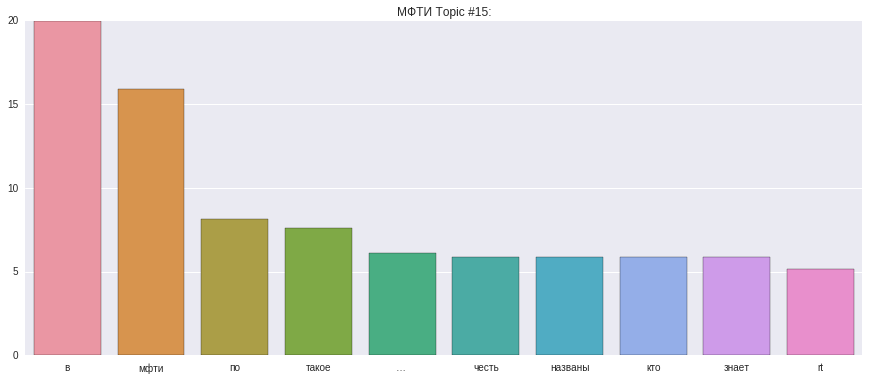

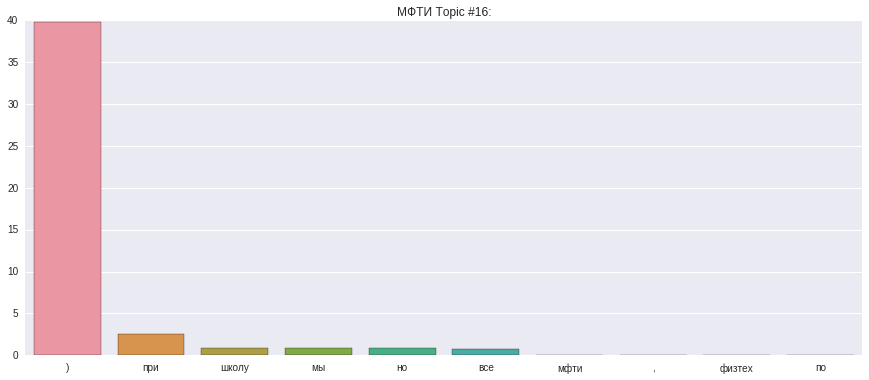

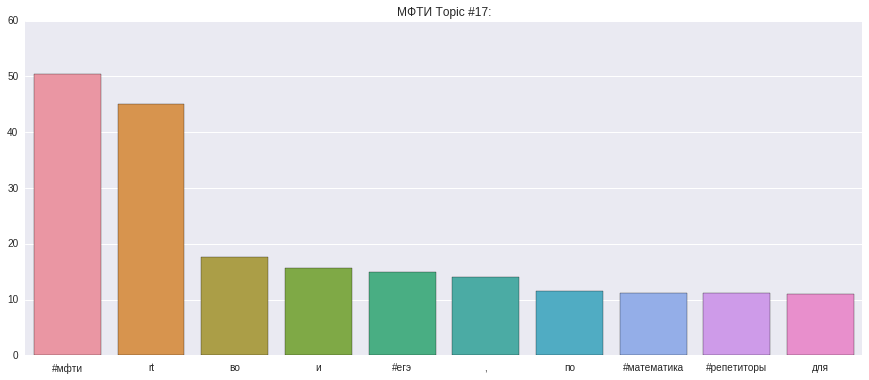

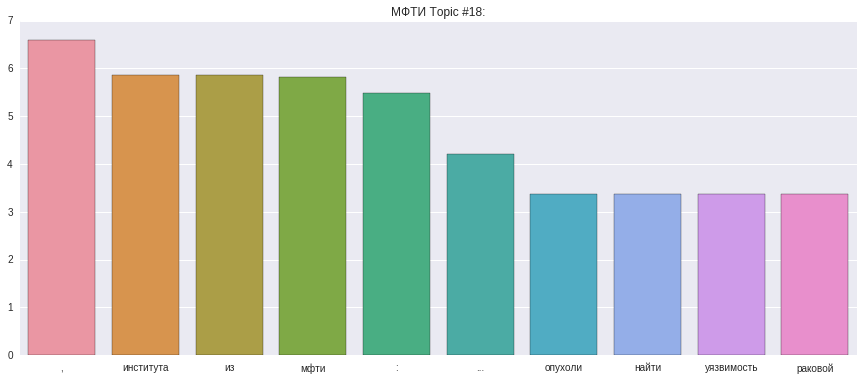

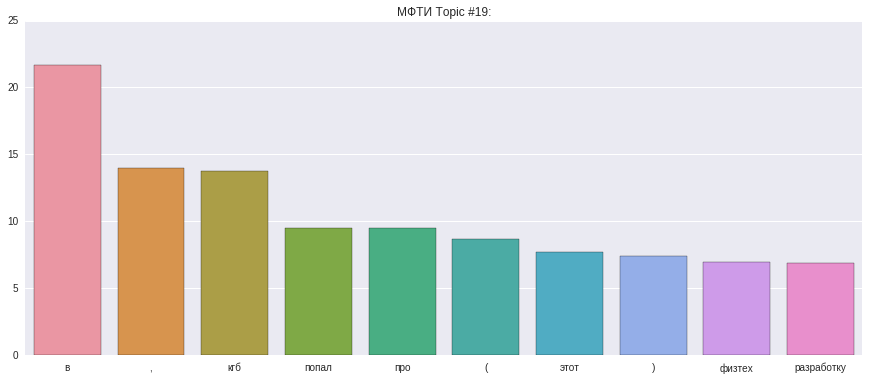

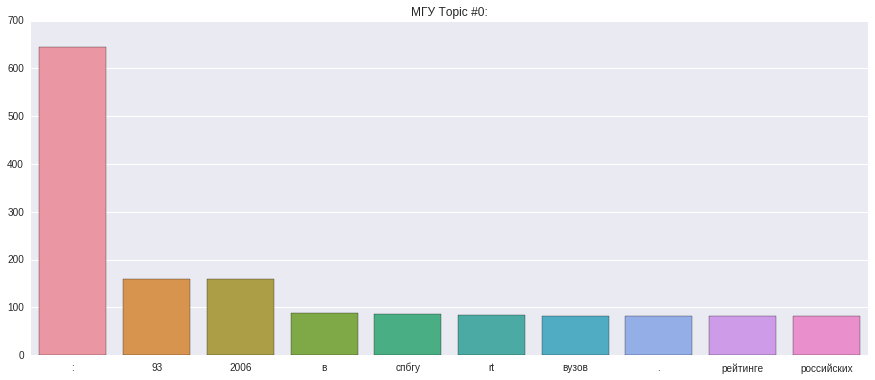

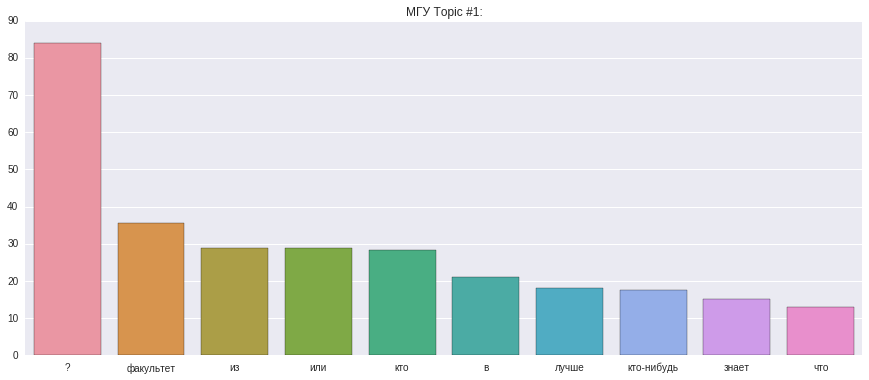

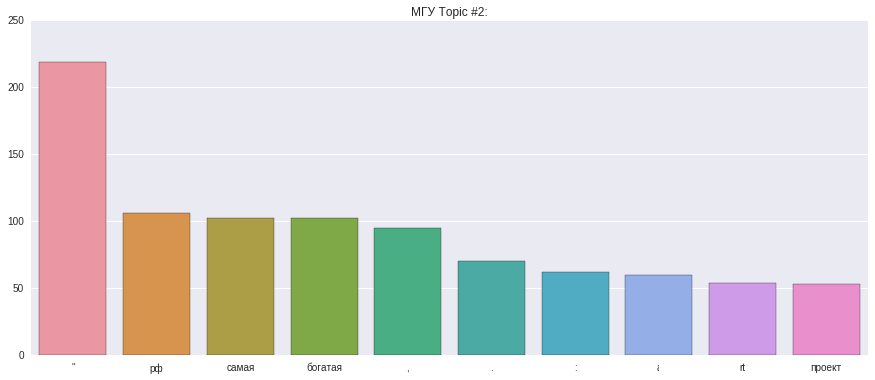

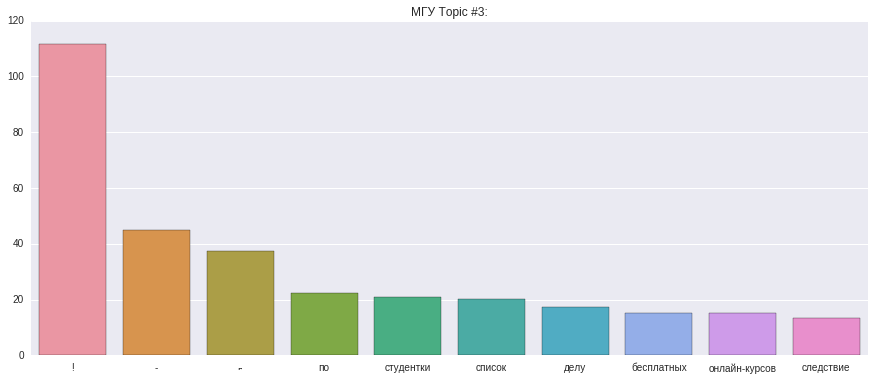

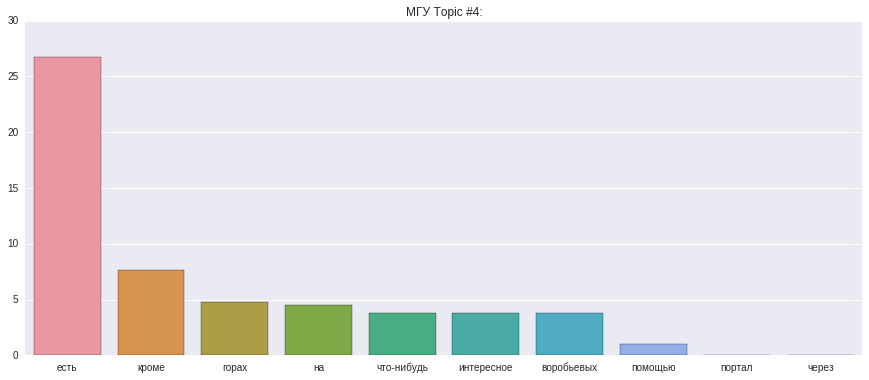

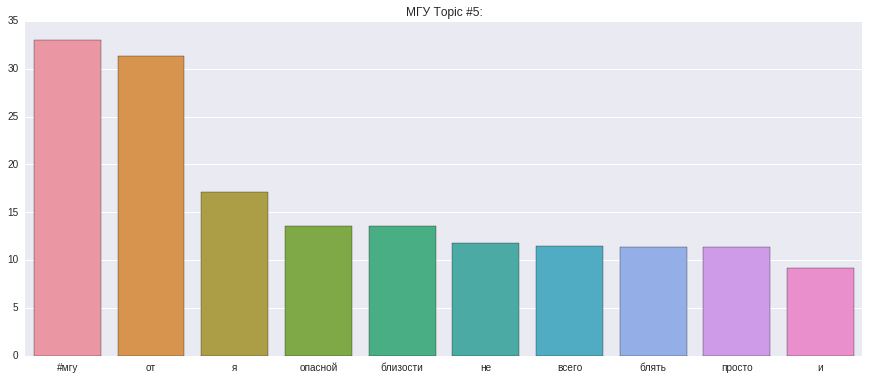

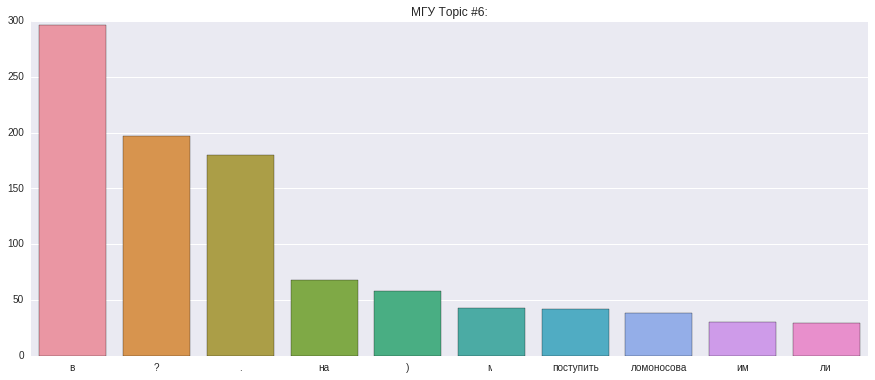

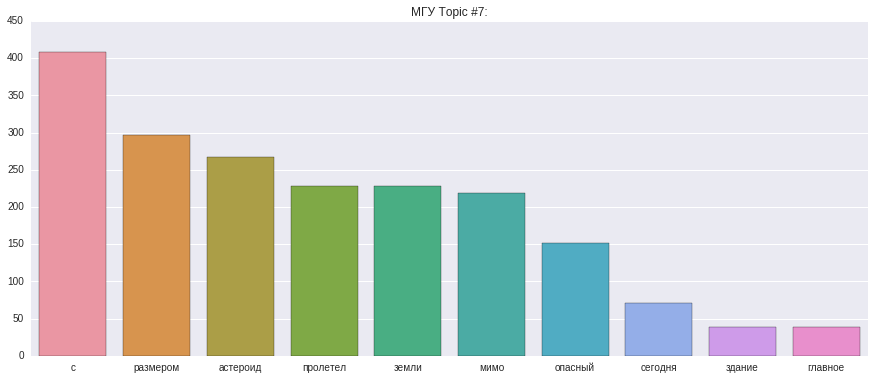

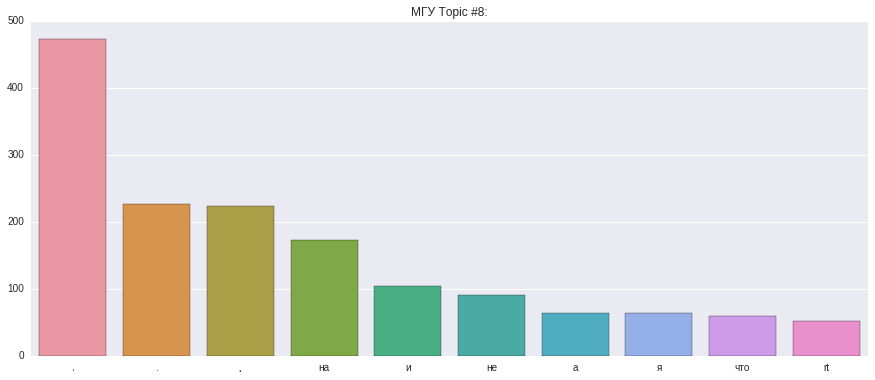

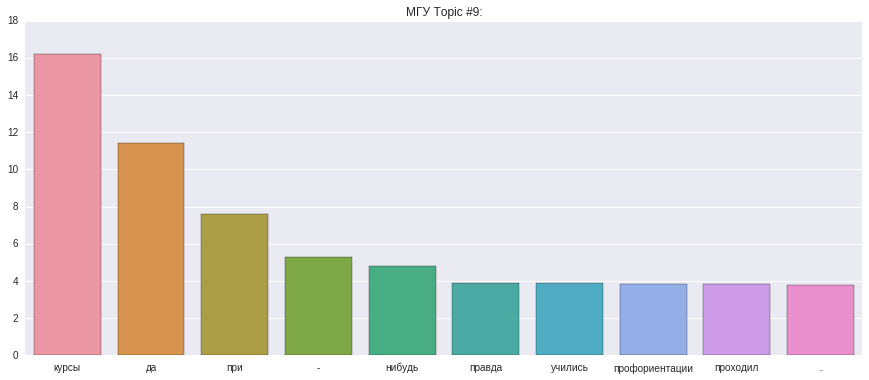

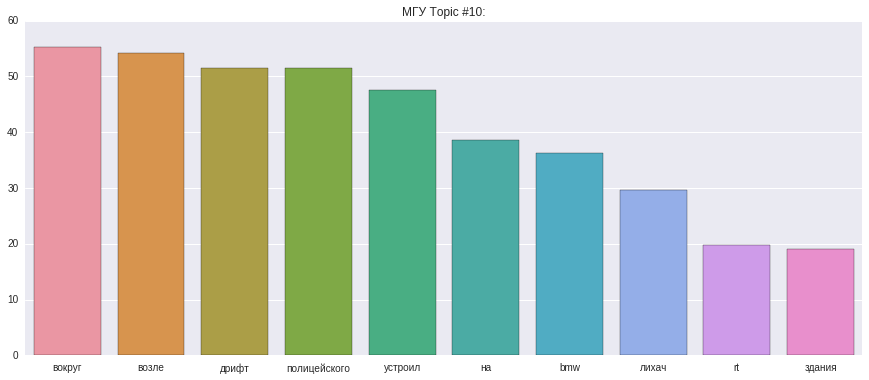

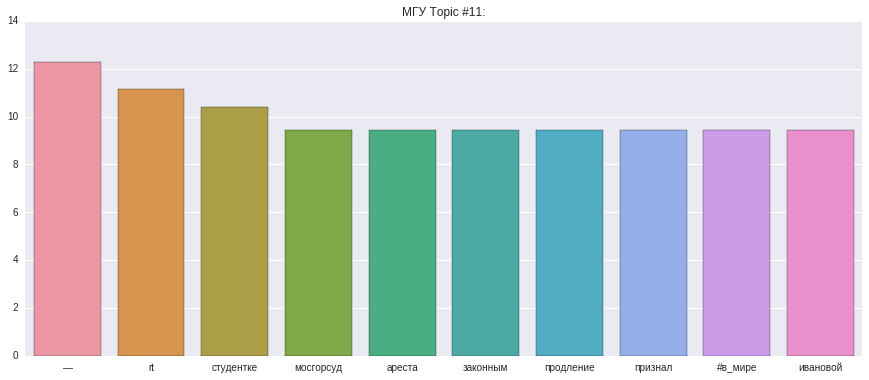

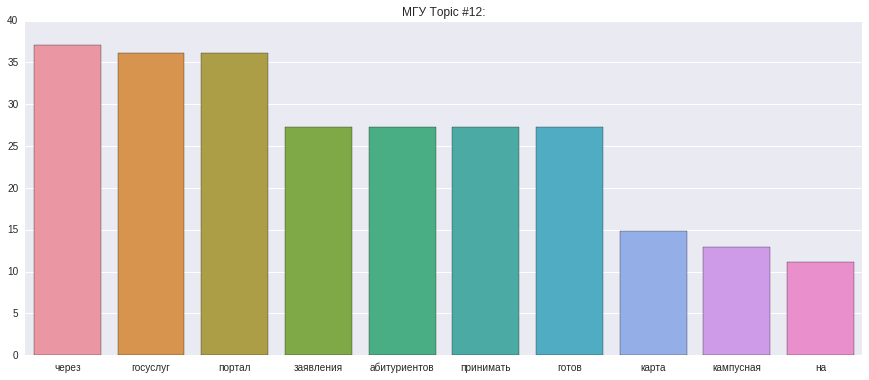

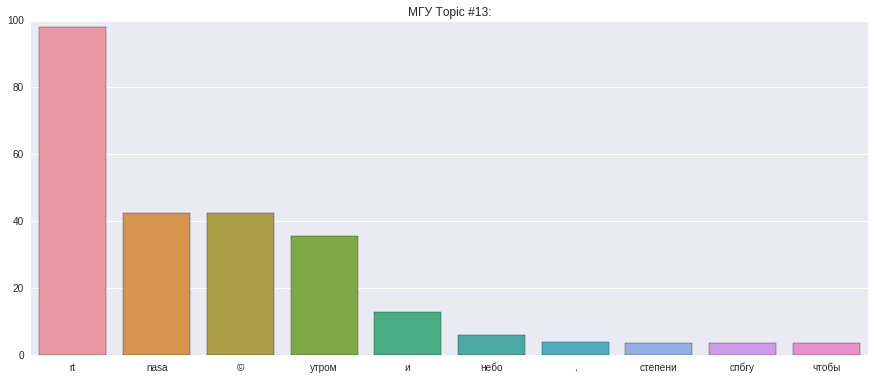

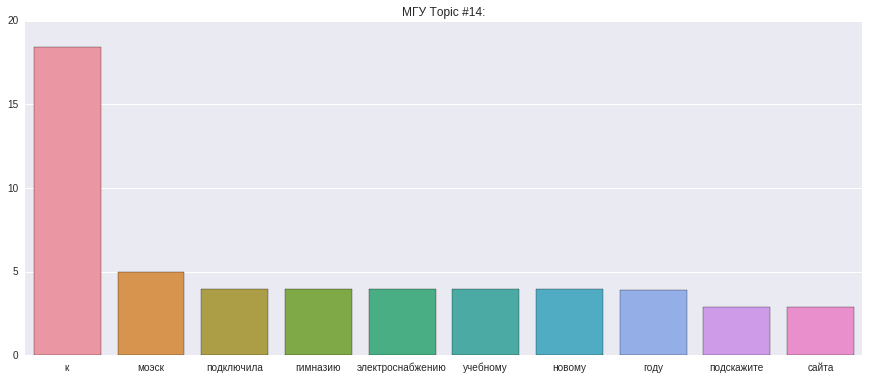

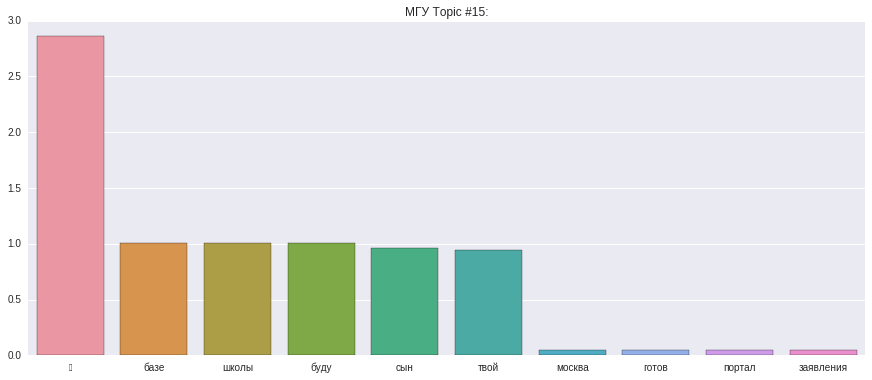

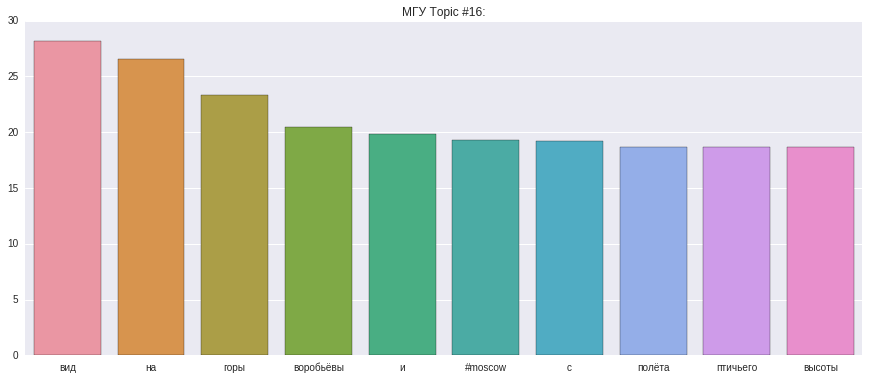

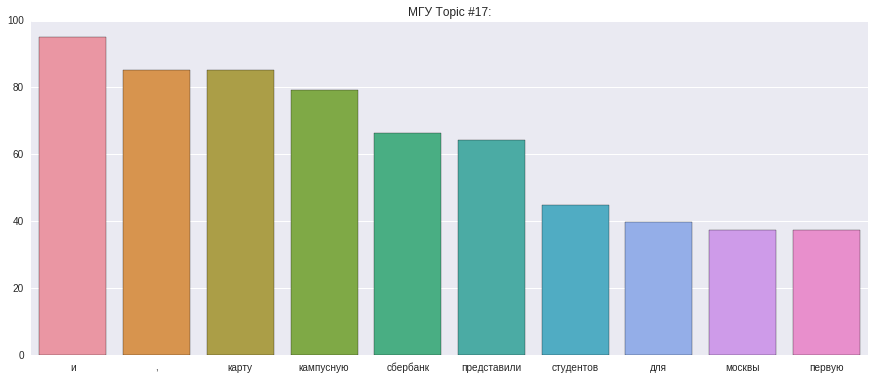

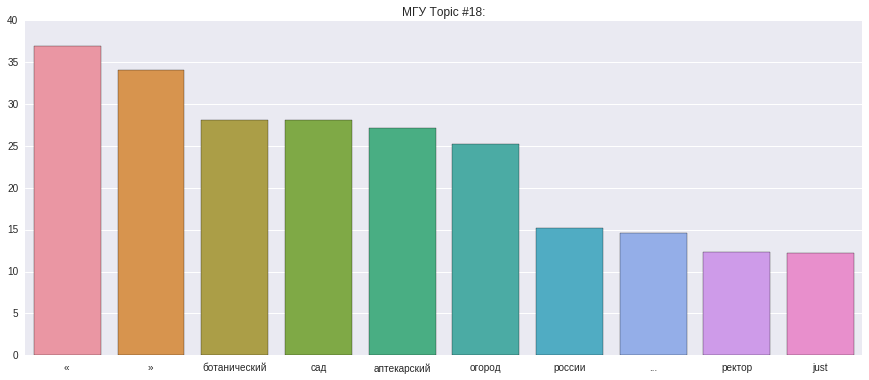

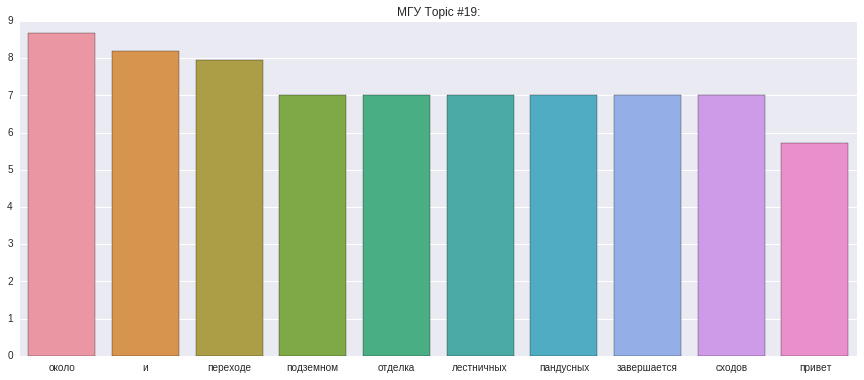

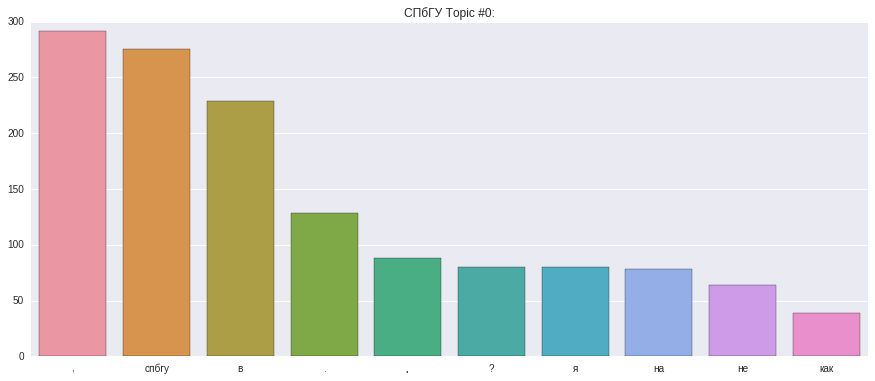

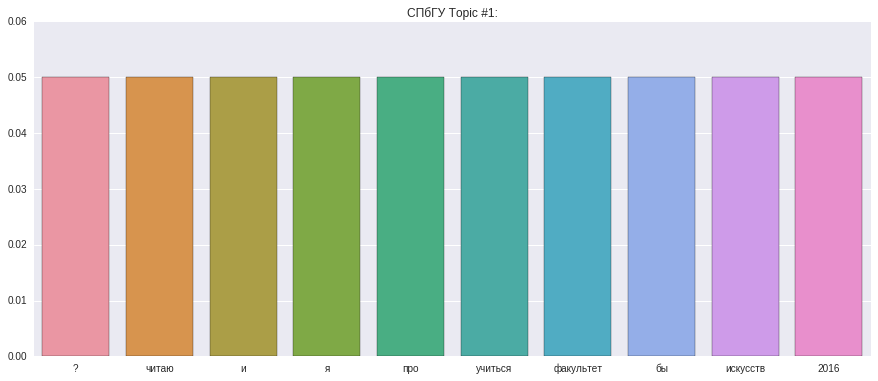

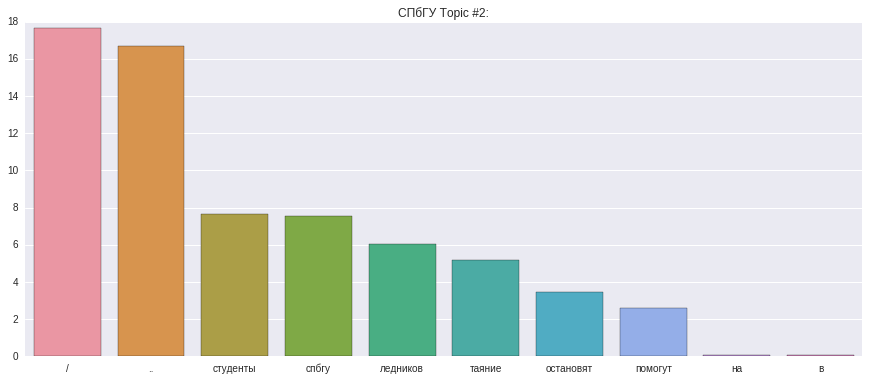

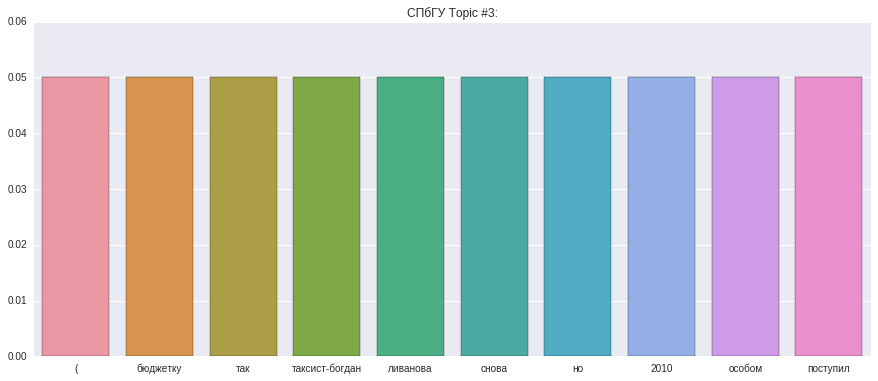

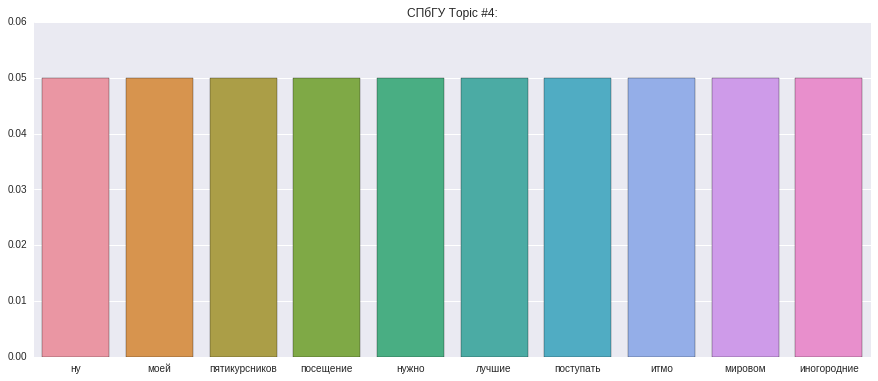

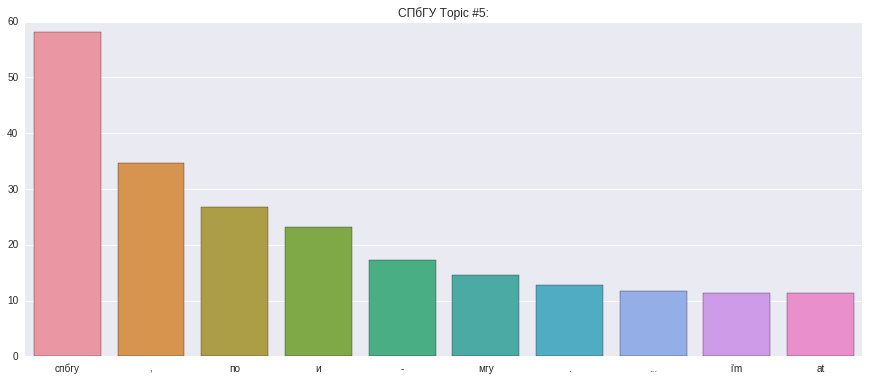

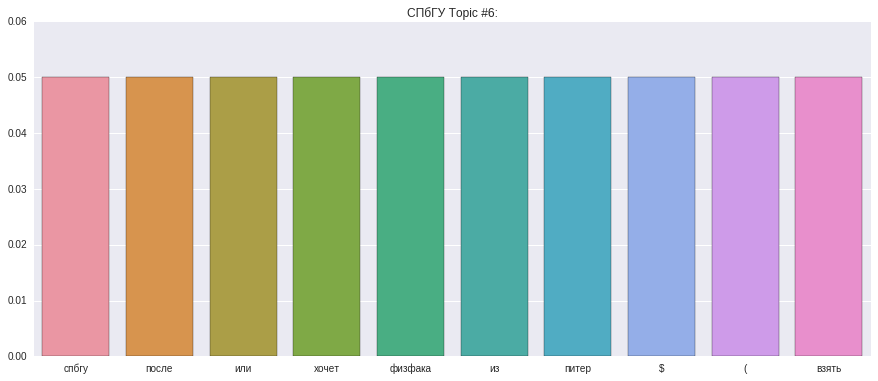

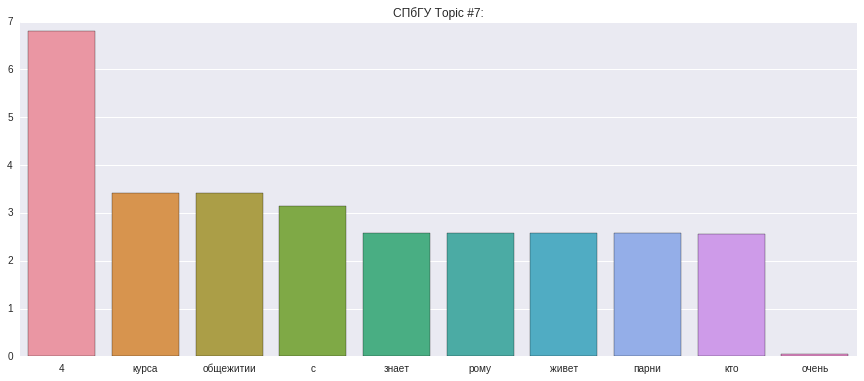

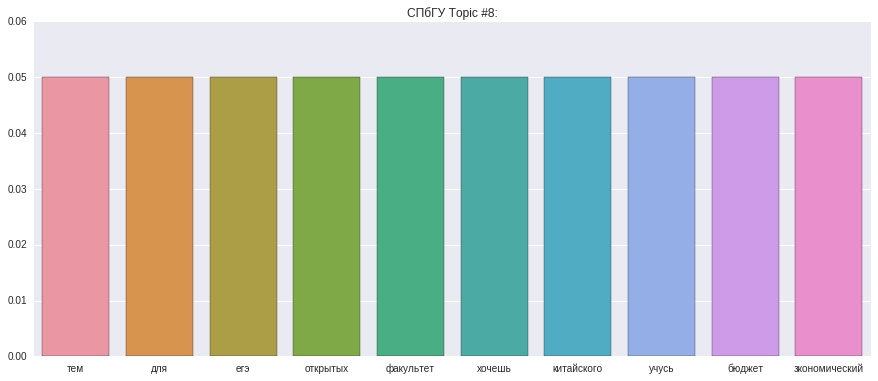

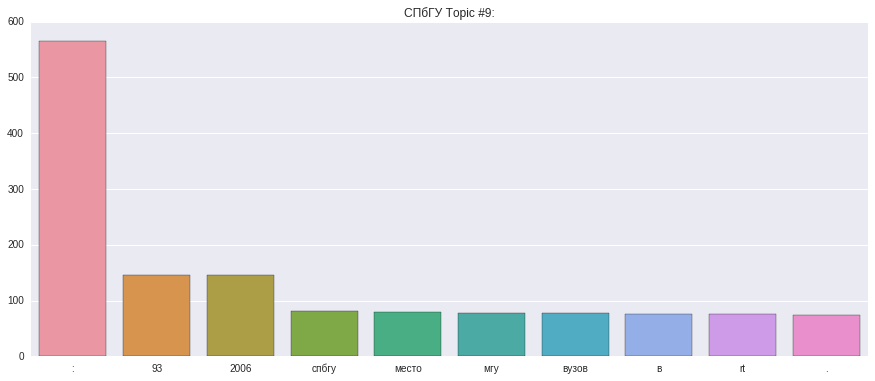

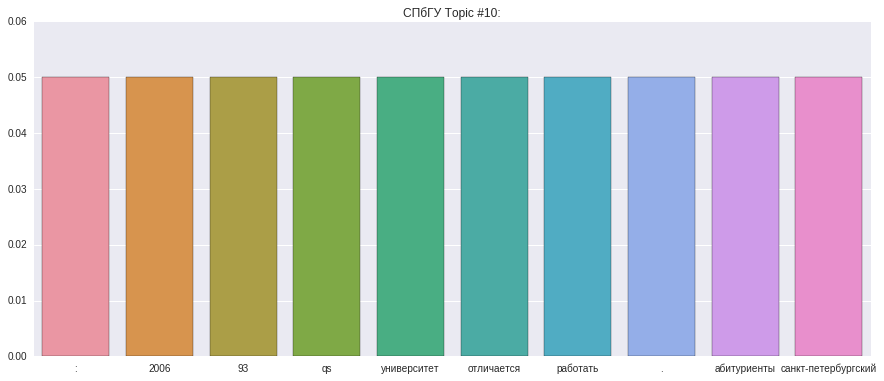

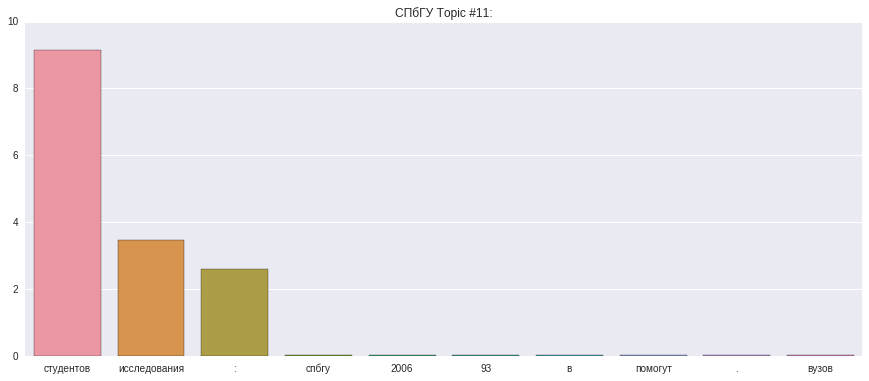

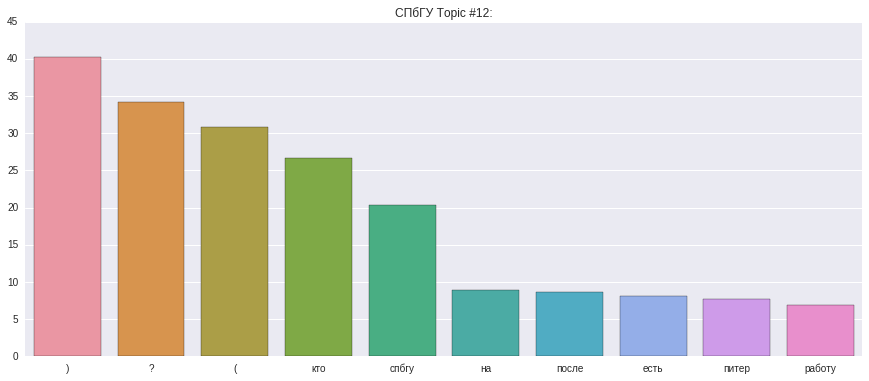

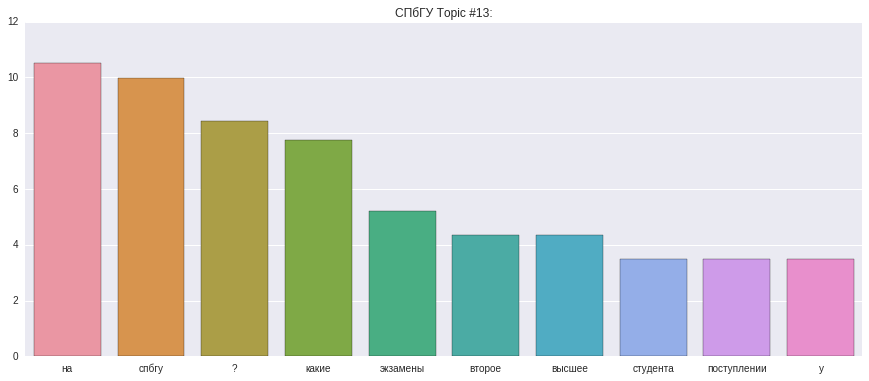

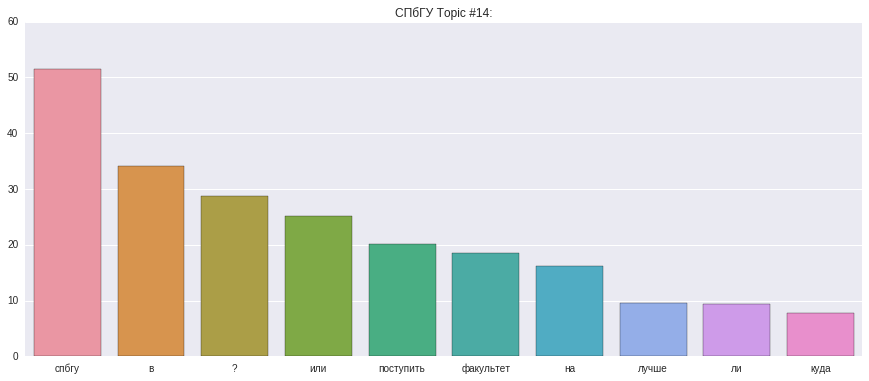

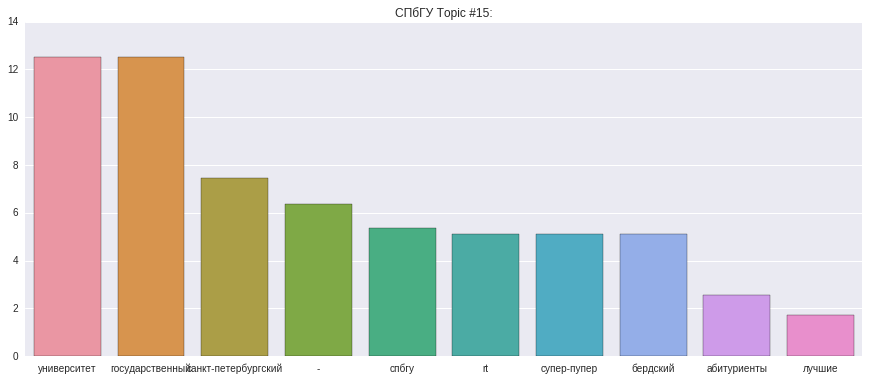

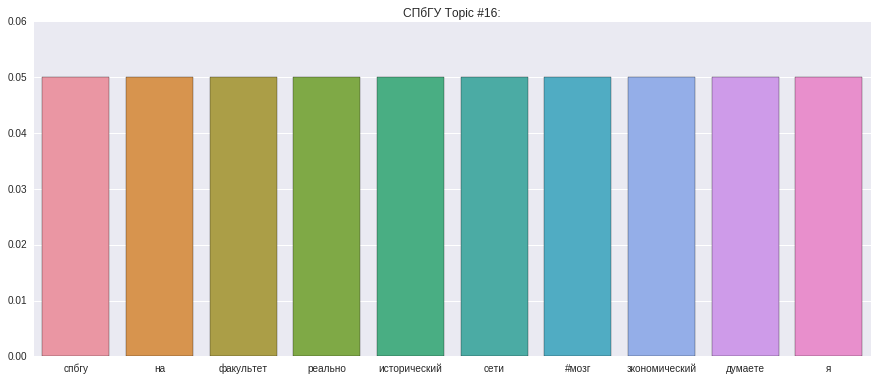

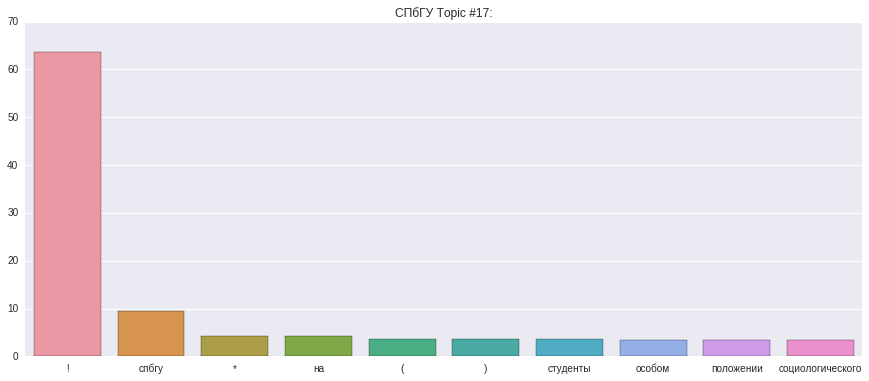

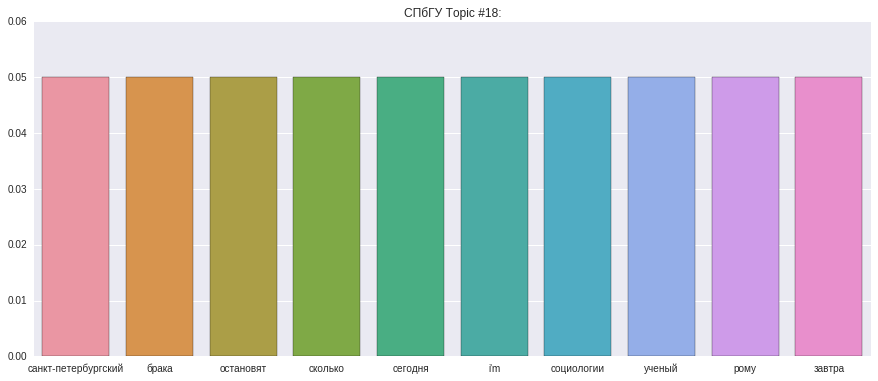

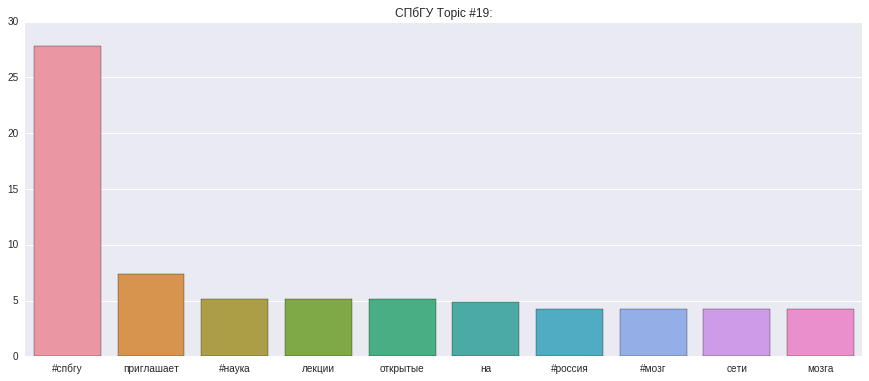

In [69]:
topics_by_university(X)

К сожалению, scikit LDA не предоставляет возможности получить распределение топиков напрямую. Поэтому приходится считать вручную, но это затрудняется тем, что LDA не возвращает нормализованные вероятности, что приводит к занулению процента некоторых топиков.

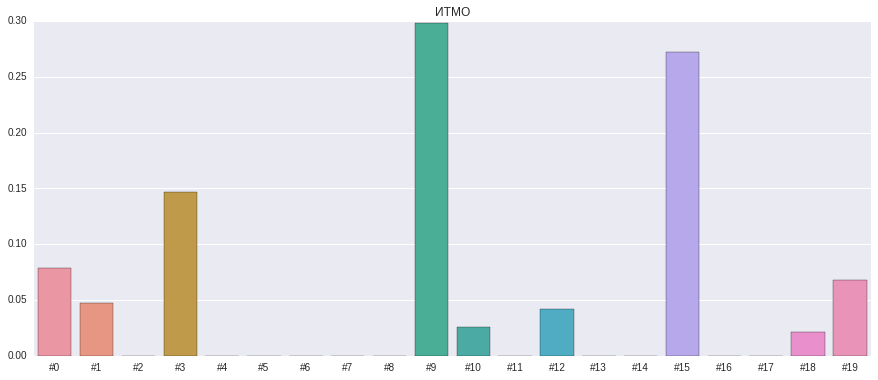

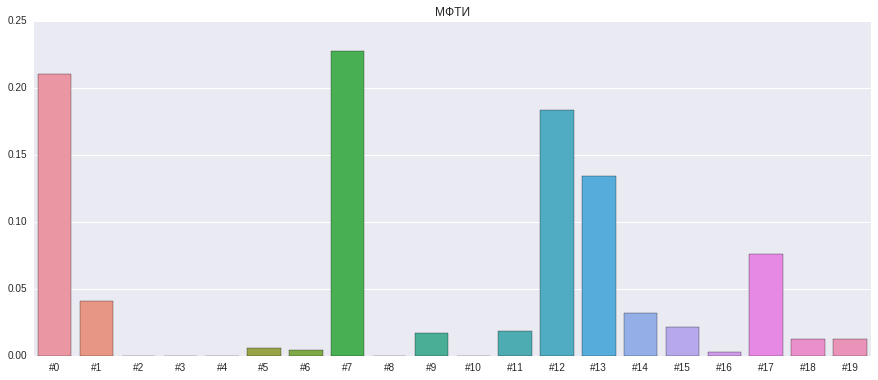

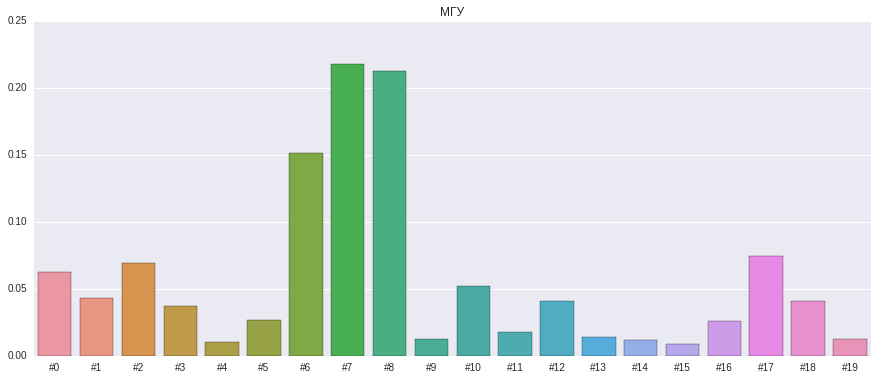

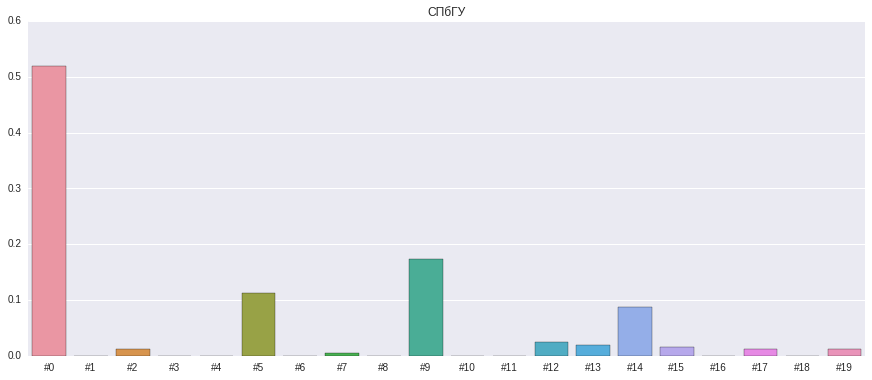

In [216]:
topics_distribution(X)